## Задача 1

Реализовать класс для работы с линейной регрессией

In [1]:
import numpy as np
import pandas as pd


class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'), градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd'). При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.

    Attributes
    ----------
    coefs_ : Вектор коэффициентов размера (p, 1), где p — количество признаков.
    intercept_ : Значение коэффициента, отвечающего за смещение
    """

    def __init__(self, regularization=None, weight_calc='matrix', lambda_1=None, lambda_2=None, batch_size=20):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регулризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регулризации l2 не задано")

        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size

        self.coefs_ = None
        self.intercept_ = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        X = np.asarray(X)
        y = np.asarray(y).reshape(-1, 1)

        n, p = X.shape
        X = np.hstack([np.ones((n, 1)), X])

        if self.weight_calc == 'matrix':
            if self.regularization == 'l2':
                I = np.eye(X.shape[1])
                I[0, 0] = 0
                self.coefs_ = np.linalg.inv(
                    X.T @ X + self.lambda_2 * I
                ) @ X.T @ y
            else:
                self.coefs_ = np.linalg.inv(X.T @ X) @ X.T @ y

        elif self.weight_calc == 'gd':
            np.random.seed(42)
            w = np.random.randn(X.shape[1], 1)

            for _ in range(1000):
                grad = self._gradient(X, y, w)
                w -= 0.01 * grad

            self.coefs_ = w

        else:
            np.random.seed(42)
            w = np.random.randn(X.shape[1], 1)
            n = len(y)

            for _ in range(1000):
                idx = np.random.permutation(n)
                for i in range(0, n, self.batch_size):
                    batch = idx[i:i + self.batch_size]
                    grad = self._gradient(X[batch], y[batch], w)
                    w -= 0.01 * grad

            self.coefs_ = w


        self.intercept_ = self.coefs_[0, 0]
        self.coefs_ = self.coefs_[1:]

        return self




    def _gradient(self, X, y, w):
        n = len(y)
        grad = (2 / n) * X.T @ (X @ w - y)

        if self.regularization in ['l1', 'l1l2']:
            grad += self.lambda_1 * np.sign(w)
            grad[0] = grad[0]

        if self.regularization in ['l2', 'l1l2']:
            grad += 2 * self.lambda_2 * w
            grad[0] = grad[0]

        return grad


    def predict(self, X: np.array):
        X = np.asarray(X)
        return X @ self.coefs_ + self.intercept_

    def score(self, X: np.array, y: np.array):
        #R^2 score
        y = np.asarray(y).reshape(-1, 1)
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - y.mean()) ** 2)
        return 1 - ss_res / ss_tot

Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

In [3]:
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 120,
})

data = pd.read_csv('Used_fiat_500_in_Italy_dataset.csv', delimiter=',')
X, y = data.drop(columns=['price']), data['price']

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = MinMaxScaler()
X_cat_cols = encoder.fit_transform(X[cat_cols])
X_num_cols = scaler.fit_transform(X[num_cols])
X_cat_cols = pd.DataFrame(X_cat_cols, columns=encoder.get_feature_names_out())
X_num_cols = pd.DataFrame(X_num_cols, columns=scaler.get_feature_names_out())
X = pd.concat([X_cat_cols,X_num_cols], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)






Numeric columns: ['engine_power', 'age_in_days', 'km', 'previous_owners', 'lat', 'lon']
Categorical columns: ['model', 'transmission']


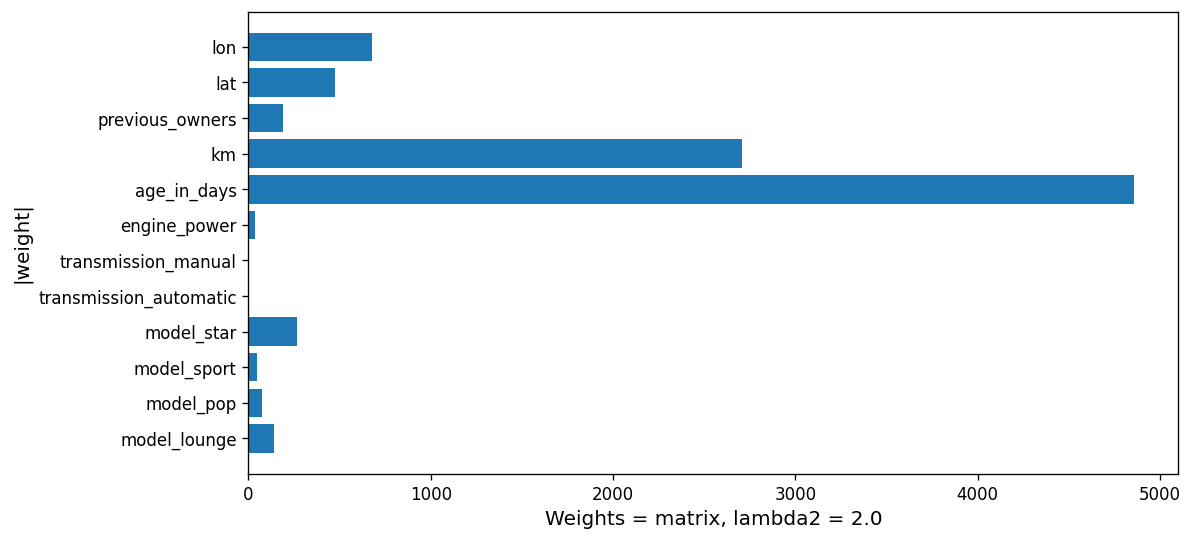

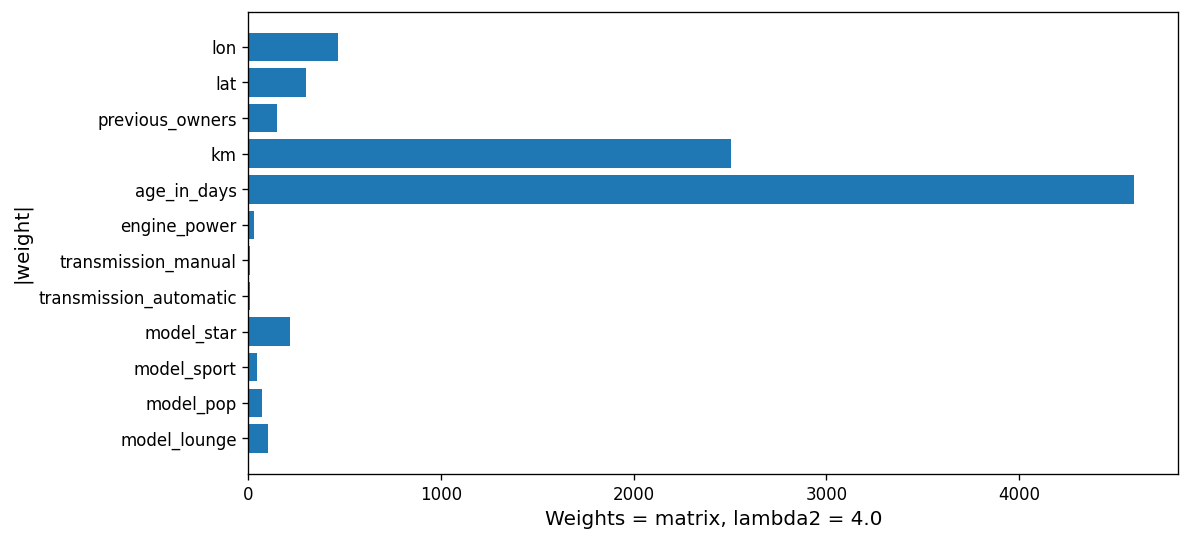

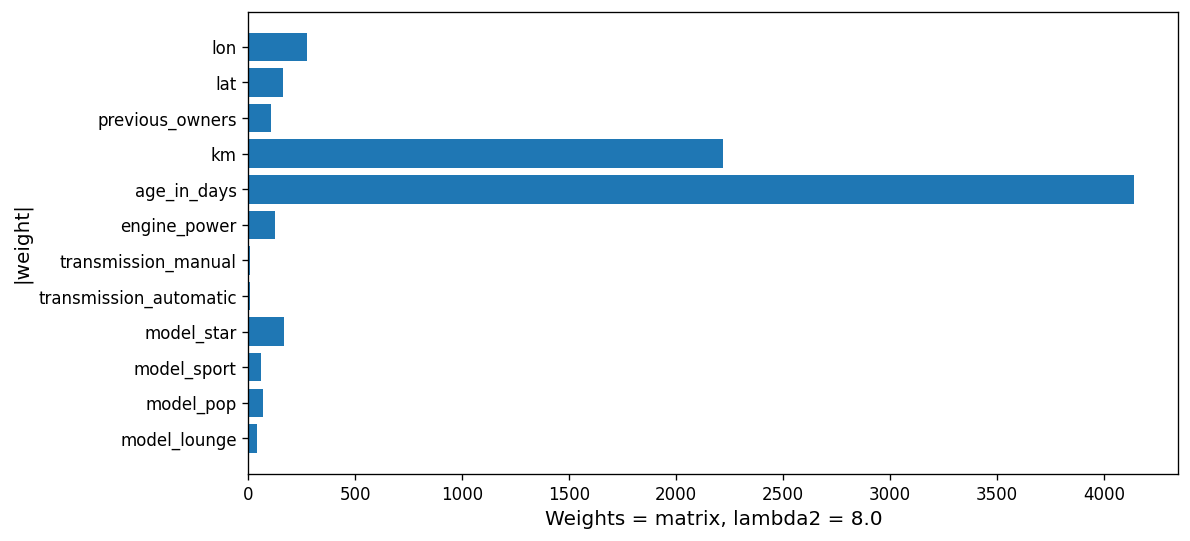

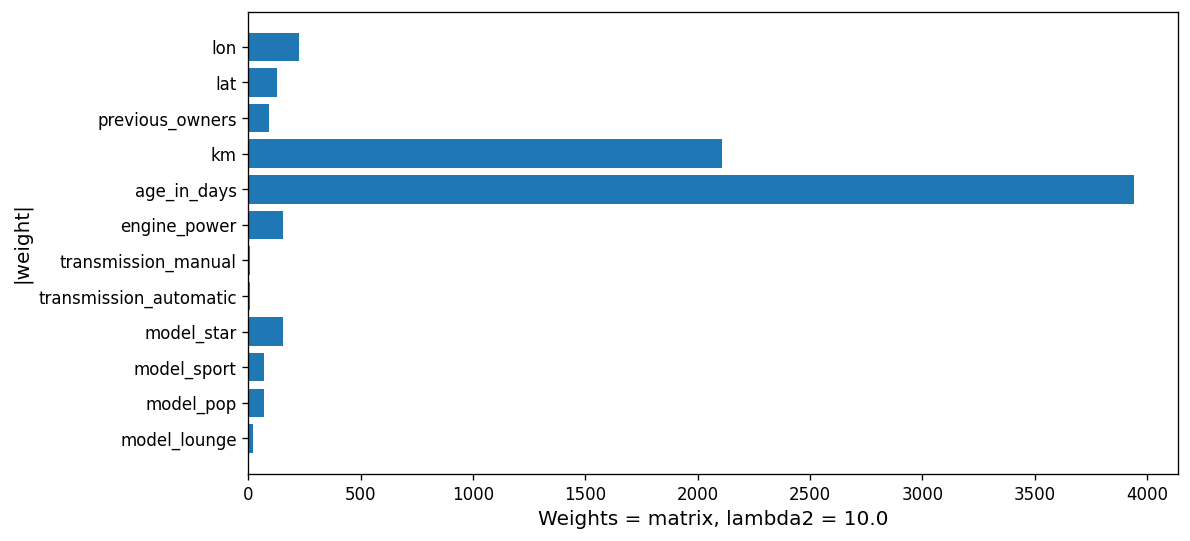

In [4]:
lambdas1 = np.arange(0.2, 10.1, 0.2)

train_mae1, val_mae1, r2_score1, train_time1 = [],[],[],[]


for l in lambdas1:
    model = MyLinearRegression('l2', 'matrix', 1, l)
    t = time.time()
    model.fit(X_train,y_train)
    train_time1.append(time.time() - t)

    score = model.score(X_test, y_test)
    r2_score1.append(score)
    train_mae1.append(np.mean(np.abs(np.asarray(y_train).reshape(-1, 1) - model.predict(X_train))))
    val_mae1.append(np.mean(np.abs(np.asarray(y_test).reshape(-1, 1) - model.predict(X_test))))

    if l in [0,0.5,2,4,6,8,10]:
        plt.barh(X_train.columns, np.abs(model.coefs_.flatten()))
        plt.xlabel("Weights = matrix, lambda2 = " + str(l))
        plt.ylabel("|weight|")
        plt.show()



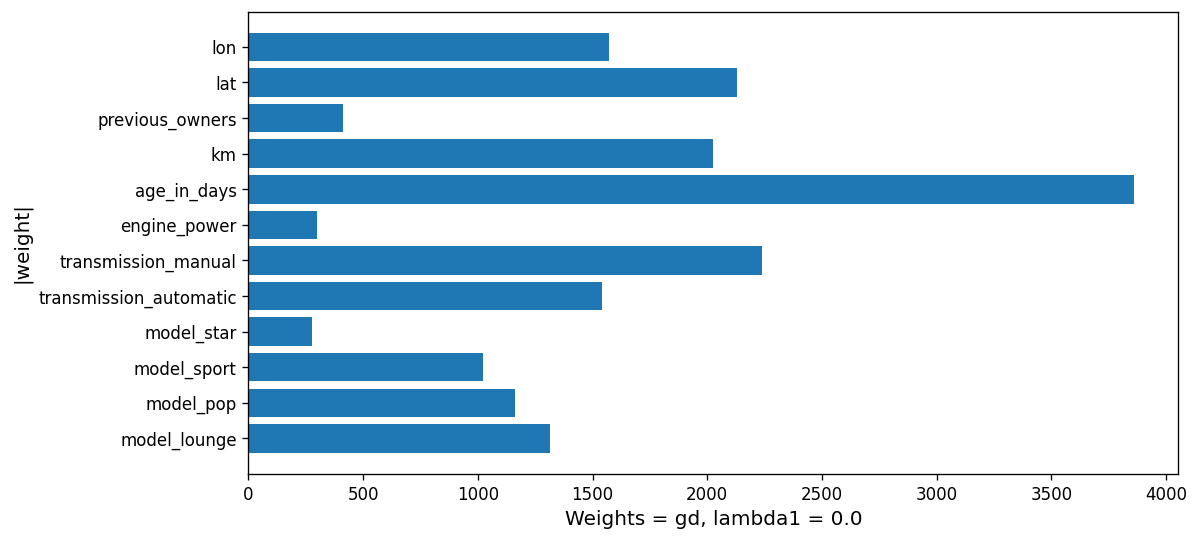

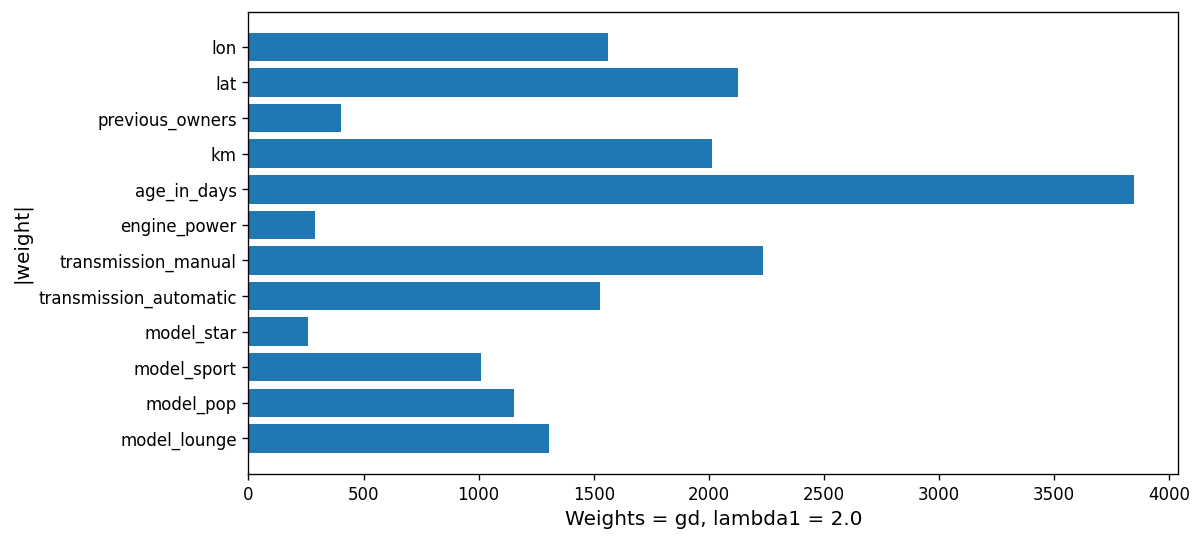

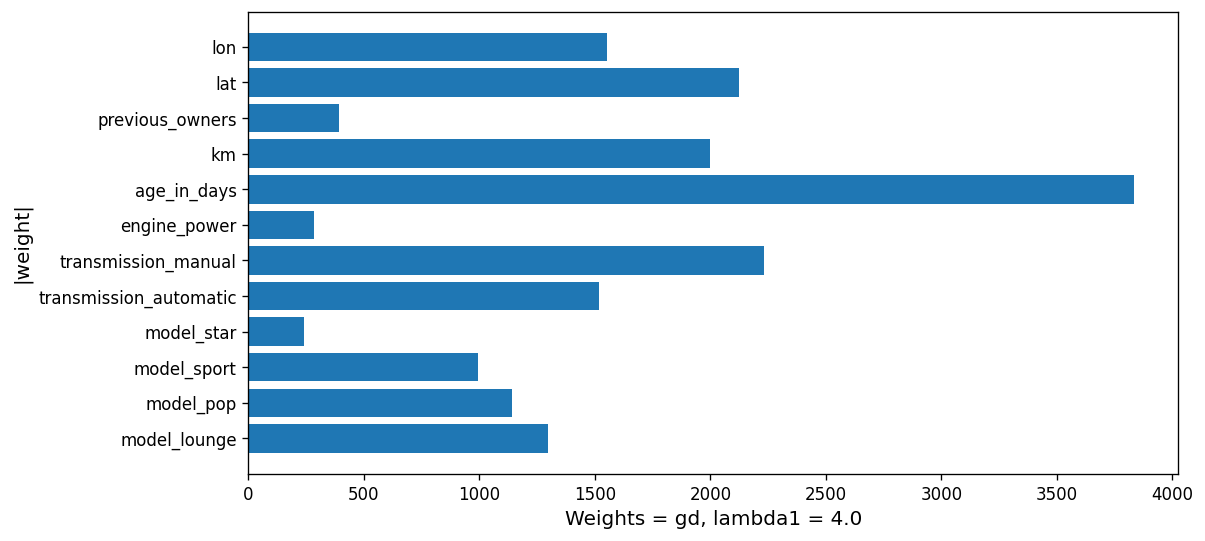

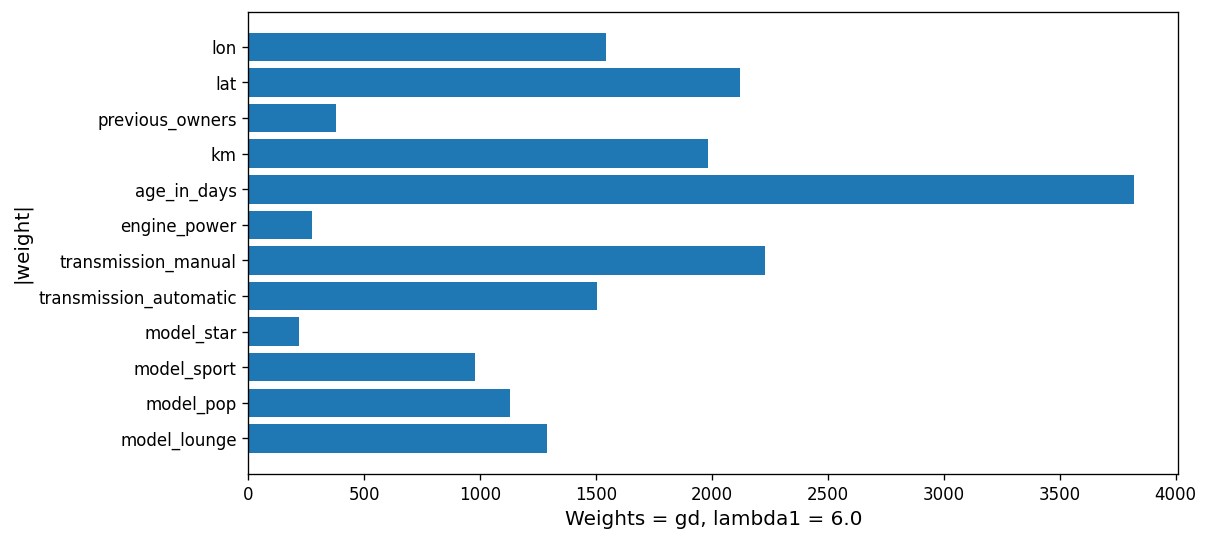

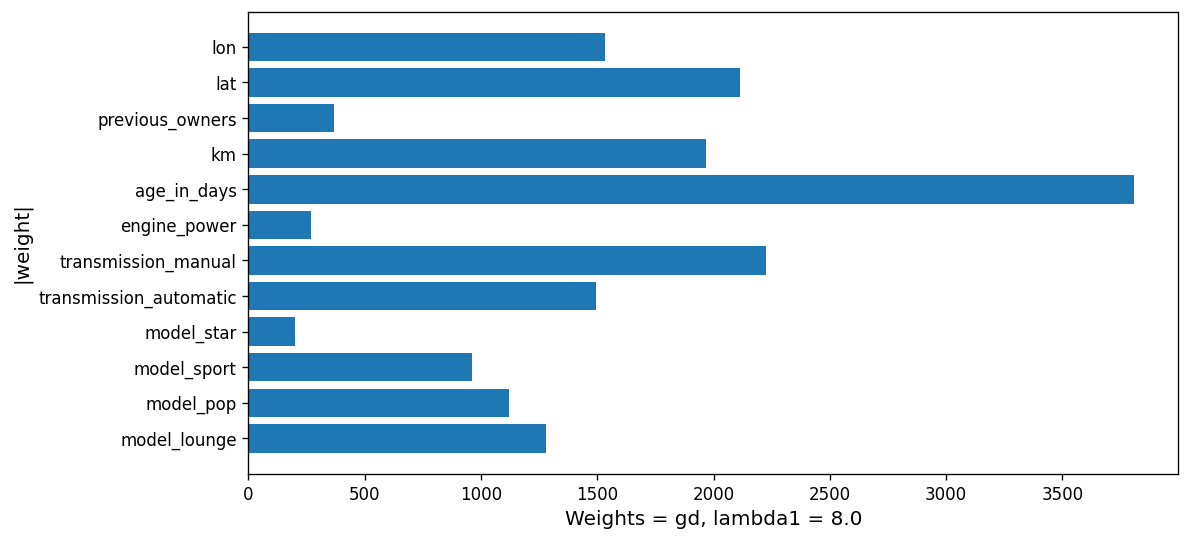

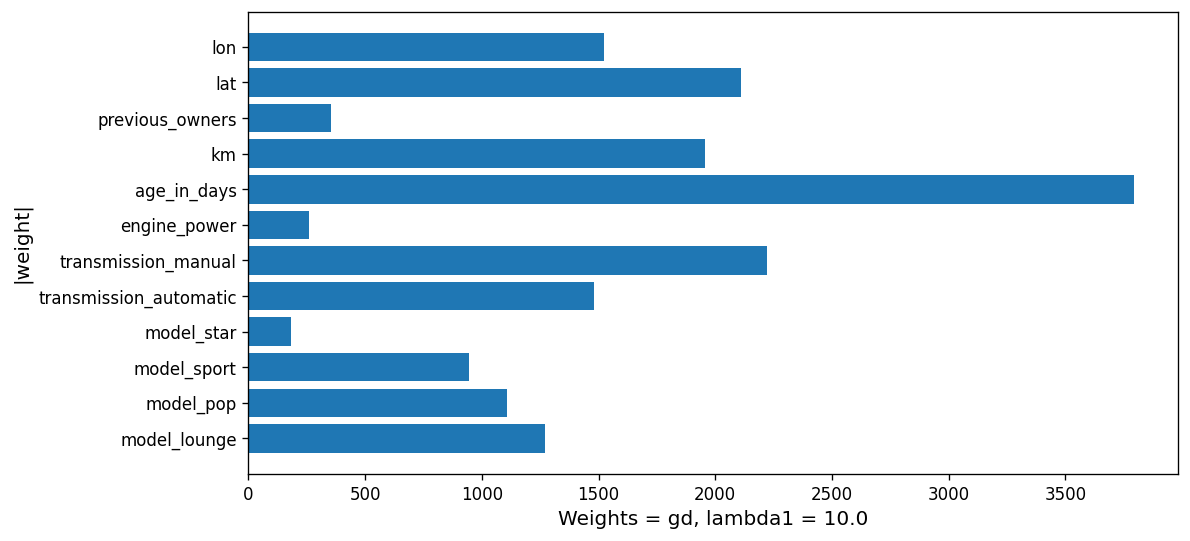

In [5]:
lambdas2 = np.arange(0, 10.01, 0.2)

train_mae2, val_mae2, r2_score2, train_time2 = [],[],[],[]


for l in lambdas2:
    model = MyLinearRegression('l1', 'gd', l)
    t = time.time()
    model.fit(X_train,y_train)
    train_time2.append(time.time() - t)

    score = model.score(X_test, y_test)
    r2_score2.append(score)
    train_mae2.append(np.mean(np.abs(np.asarray(y_train).reshape(-1, 1) - model.predict(X_train))))
    val_mae2.append(np.mean(np.abs(np.asarray(y_test).reshape(-1, 1) - model.predict(X_test))))

    if l in [0,0.5,2,4,6,8,10]:
        plt.barh(X_train.columns, np.abs(model.coefs_.flatten()))
        plt.xlabel("Weights = gd, lambda1 = " + str(l))
        plt.ylabel("|weight|")
        plt.show()

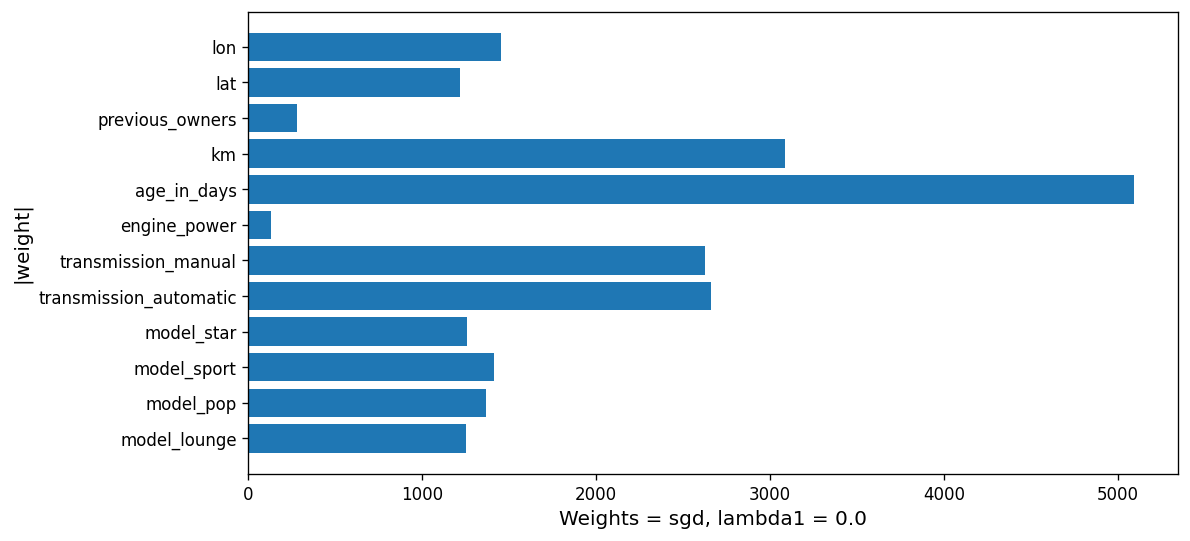

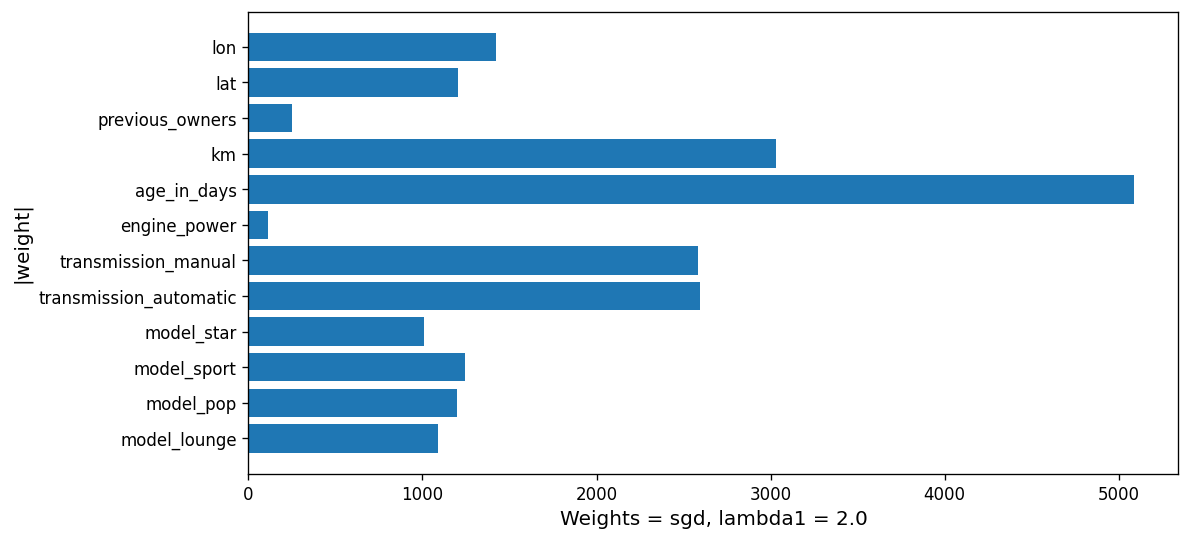

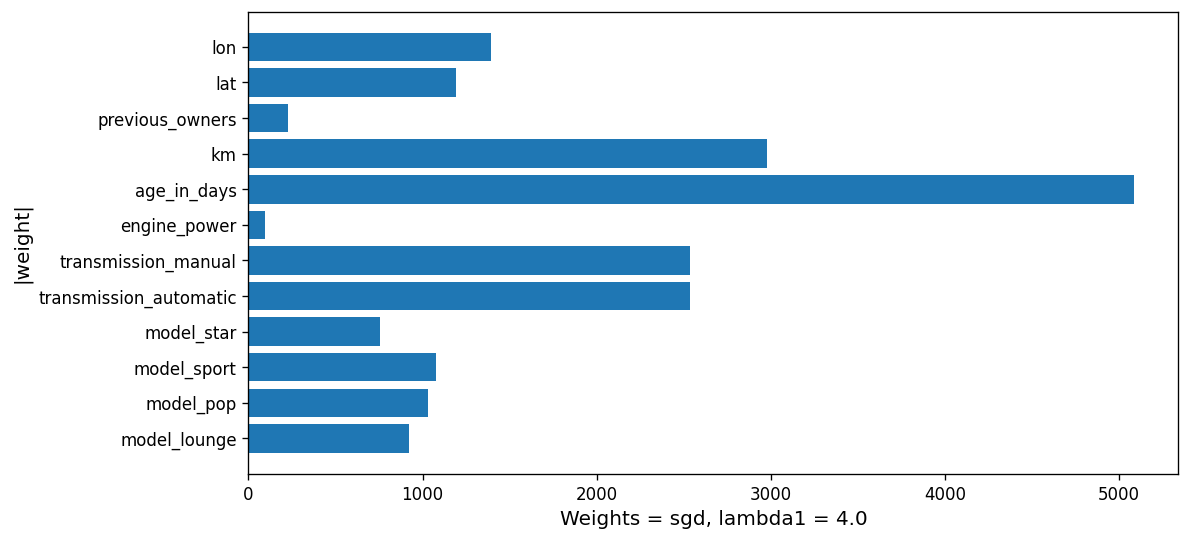

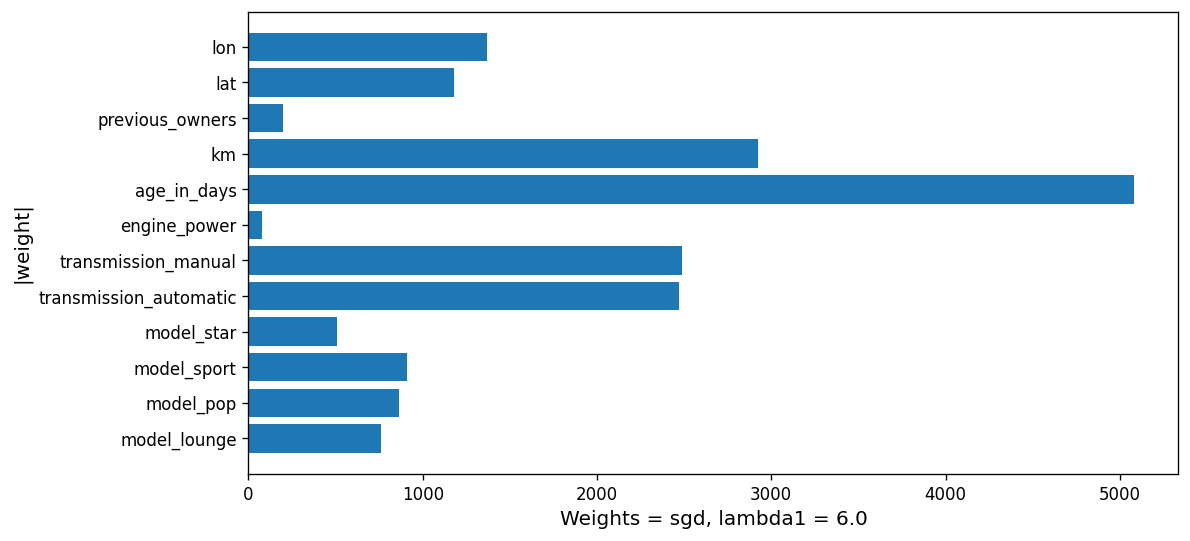

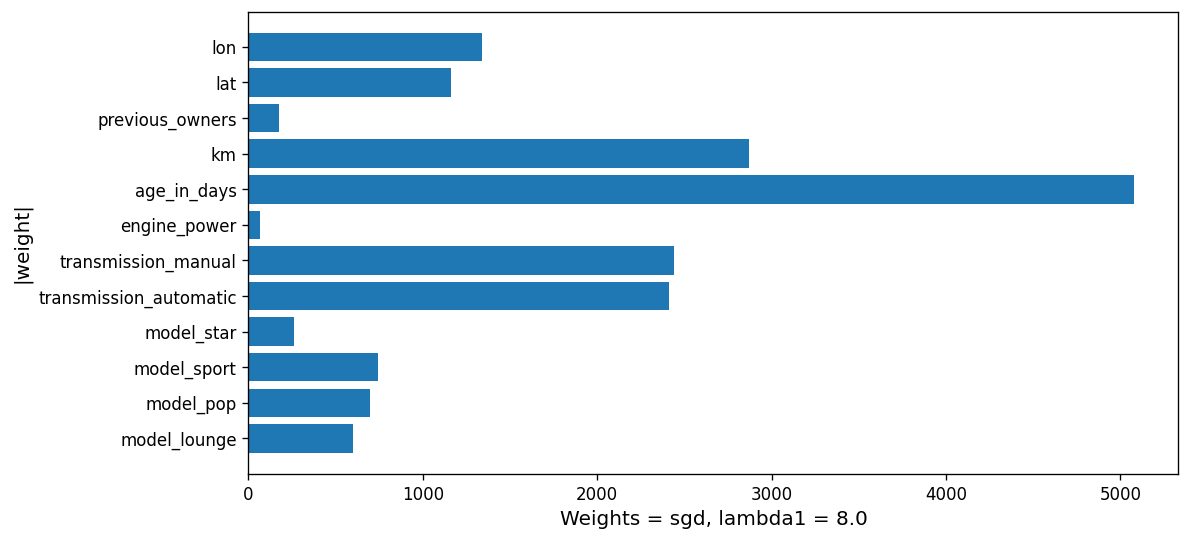

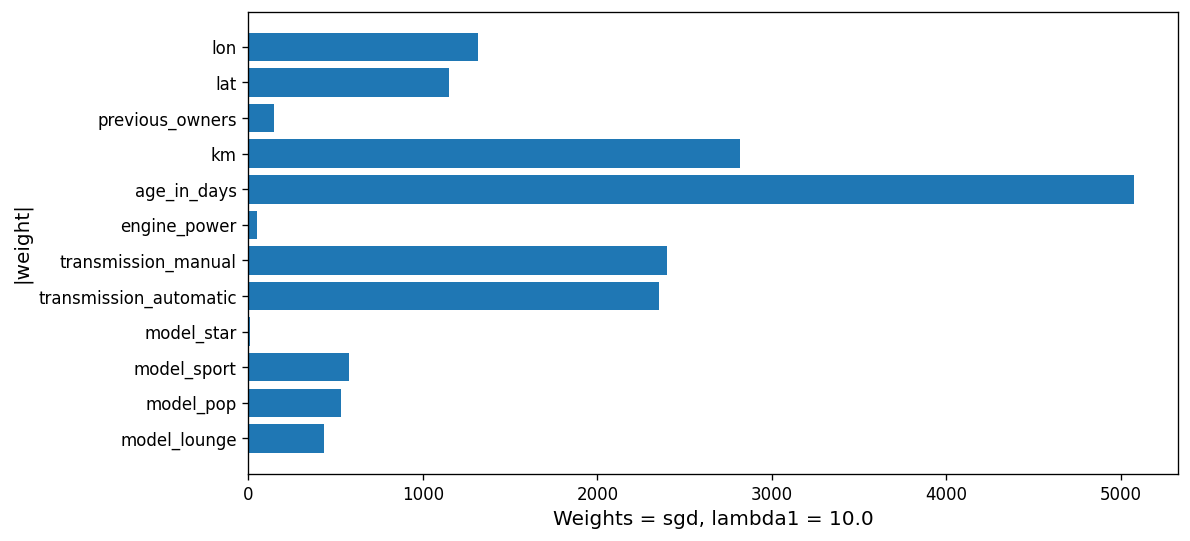

In [12]:


train_mae3, val_mae3, r2_score3, train_time3 = [],[],[],[]


for l in lambdas2:
    model = MyLinearRegression('l1', 'sgd', l)
    t = time.time()
    model.fit(X_train,y_train)
    train_time3.append(time.time() - t)

    score = model.score(X_test, y_test)
    r2_score3.append(score)
    train_mae3.append(np.mean(np.abs(np.asarray(y_train).reshape(-1, 1) - model.predict(X_train))))
    val_mae3.append(np.mean(np.abs(np.asarray(y_test).reshape(-1, 1) - model.predict(X_test))))

    if l in [0,0.5,2,4,6,8,10]:
        plt.barh(X_train.columns, np.abs(model.coefs_.flatten()))
        plt.xlabel("Weights = sgd, lambda1 = " + str(l))
        plt.ylabel("|weight|")
        plt.show()

train_mae_l1, val_mae_l1, r2_score_l1, train_time_l1 = train_mae3, val_mae3, r2_score3, train_time3

Выводы: Все модели показывают большую значимость пробега и возраста. Трансмиссия тоже крайне важна для градиентных спусков, но модель с весами вычисляемыми по матрице зануляет этот признак (и режет все остальные кроме пробега и возраста). Также зануляется model_star в sgd. С ростом lambda1 сжимаются незначимые признаки.

Text(0, 0.5, 'MAE')

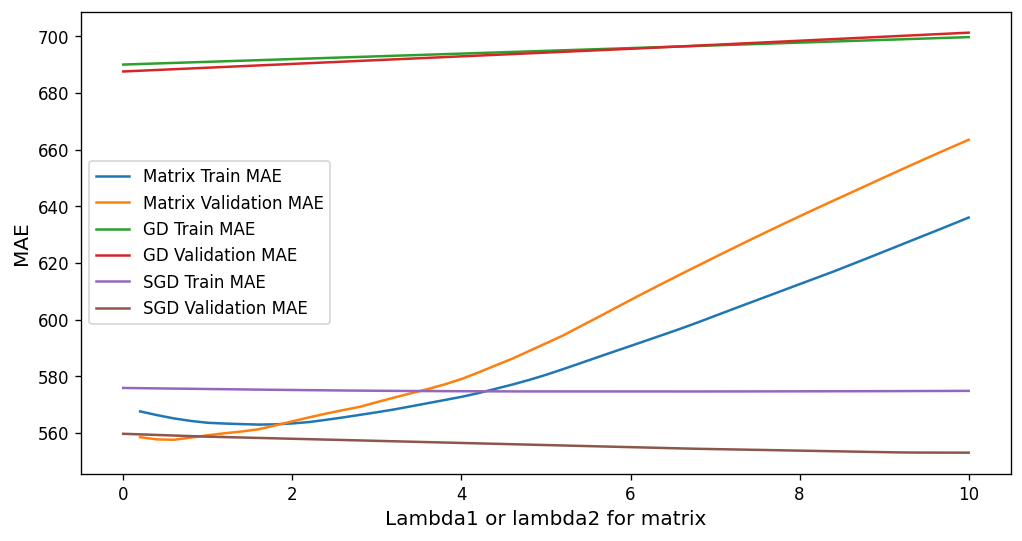

In [ ]:
plt.plot(lambdas1, train_mae1, label = 'Matrix Train MAE')
plt.plot(lambdas1, val_mae1, label = 'Matrix Validation MAE')
plt.plot(lambdas2, train_mae2, label = 'GD Train MAE')
plt.plot(lambdas2, val_mae2, label = 'GD Validation MAE')
plt.plot(lambdas2, train_mae3, label = 'SGD Train MAE')
plt.plot(lambdas2, val_mae3, label = 'SGD Validation MAE')
plt.legend()
plt.xlabel('Lambda1 or lambda2 for matrix')
plt.ylabel('MAE')

Text(0, 0.5, 'R^2 score')

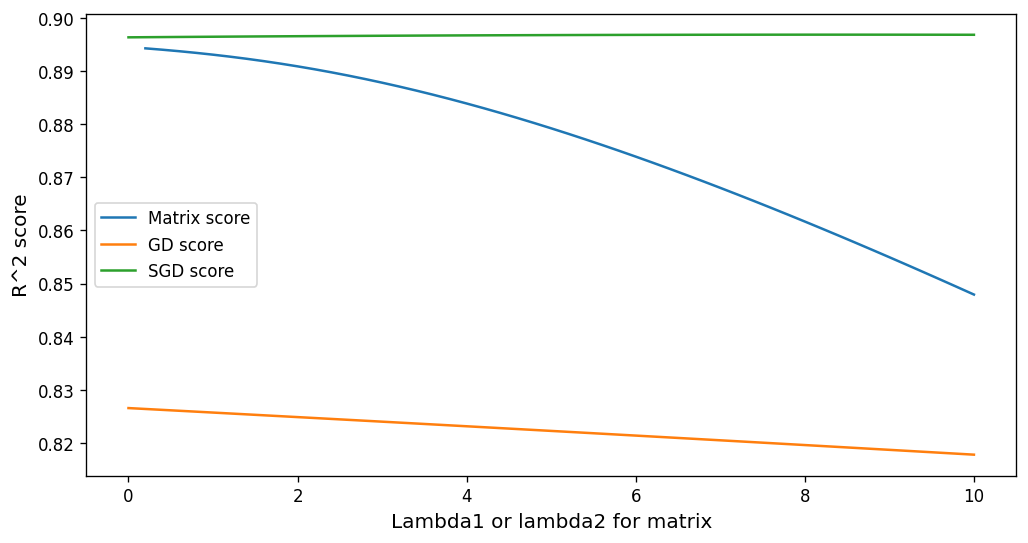

In [ ]:
plt.plot(lambdas1, r2_score1, label = 'Matrix score')
plt.plot(lambdas2, r2_score2, label = 'GD score')
plt.plot(lambdas2, r2_score3, label = 'SGD score')

plt.legend()
plt.xlabel('Lambda1 or lambda2 for matrix')
plt.ylabel('R^2 score')

Выводы: MAE на трейне и валидации почти всегда коррелируют. Обе метрики показывают, что оптимальная lambda2 для метода с матрицами близка к нулю (но не равна, так как без регуляризации он показывает ужасные результаты, видимо плохо обращаются матрицы). Те же самые тренды можно увидеть и у lambda1 у метода GD. SGD однако показывает лучшее MAE с ростом lambda1, но прирост качества незначительный. В целом SGD показывает наилучшие результаты.

Text(0, 0.5, 'Time')

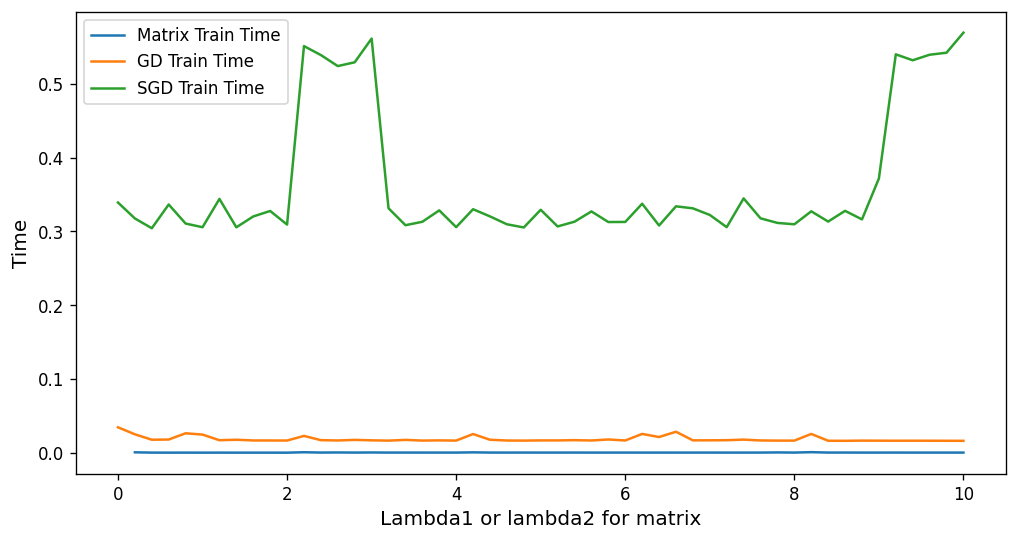

In [ ]:
plt.plot(lambdas1, train_time1, label = 'Matrix Train Time')
plt.plot(lambdas2, train_time2, label = 'GD Train Time')
plt.plot(lambdas2, train_time3, label = 'SGD Train Time')

plt.legend()
plt.xlabel('Lambda1 or lambda2 for matrix')
plt.ylabel('Time')

Методы matrix и GD в целом идут вровень по времени обучения, хотя последний незначительно медленне. Стохастический GD в свою очередь имеет как более высокое среднее время обучения, так и значительно большую его дисперсию.

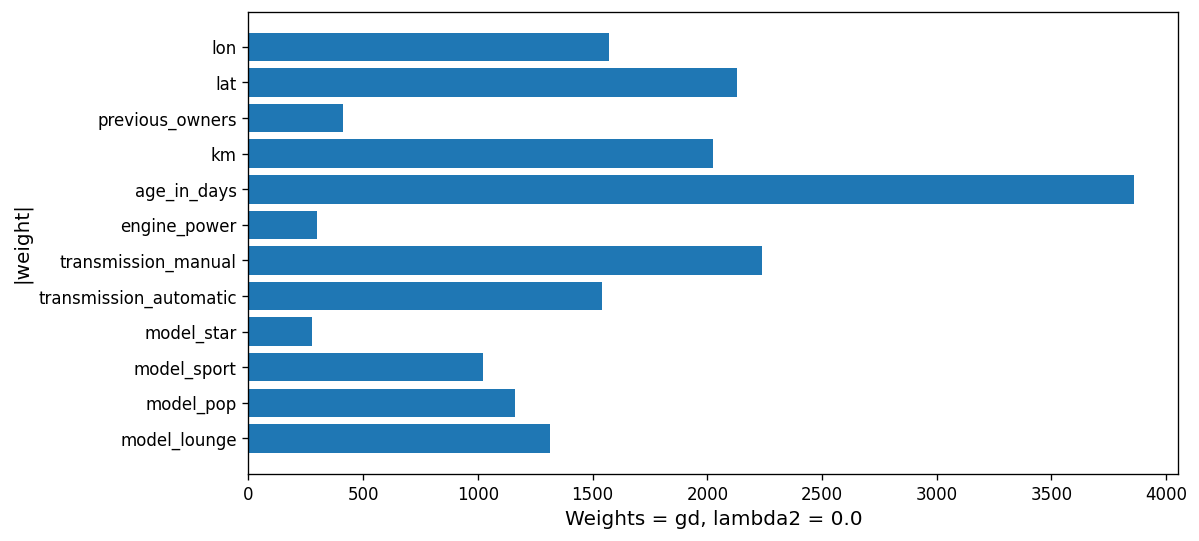

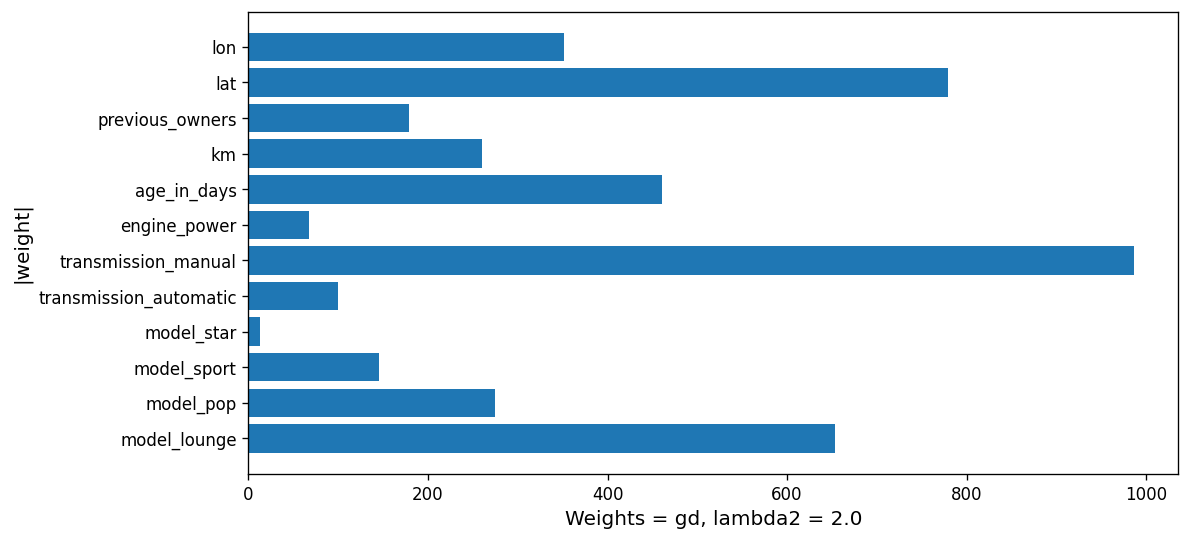

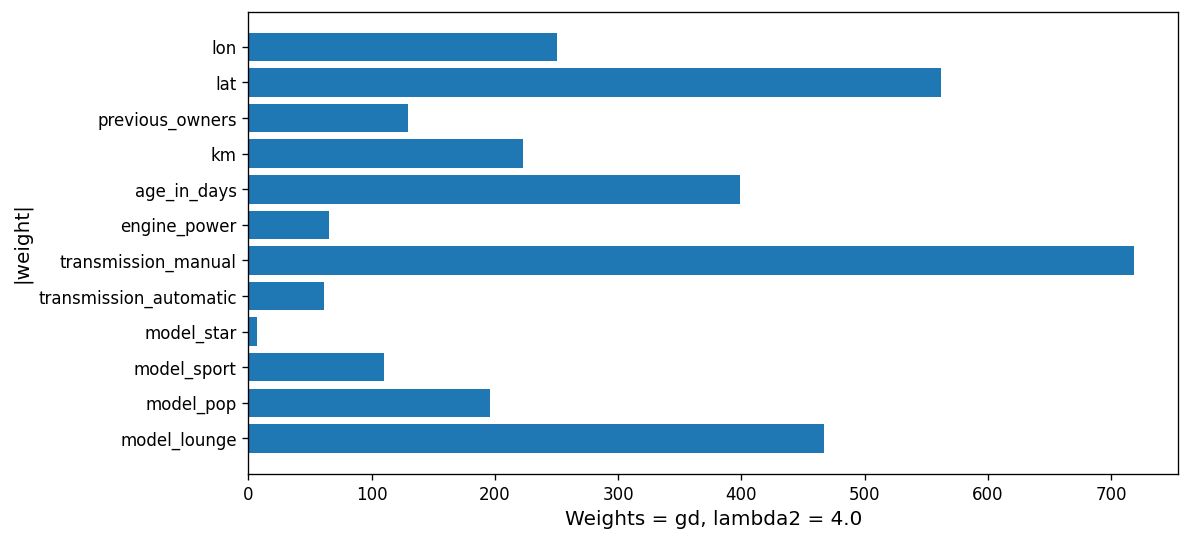

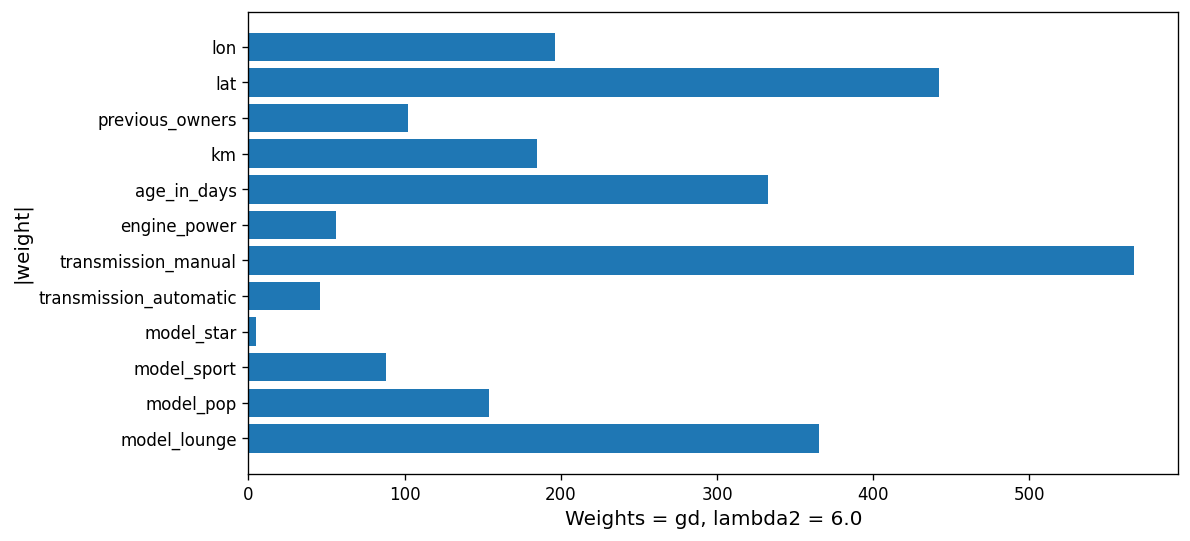

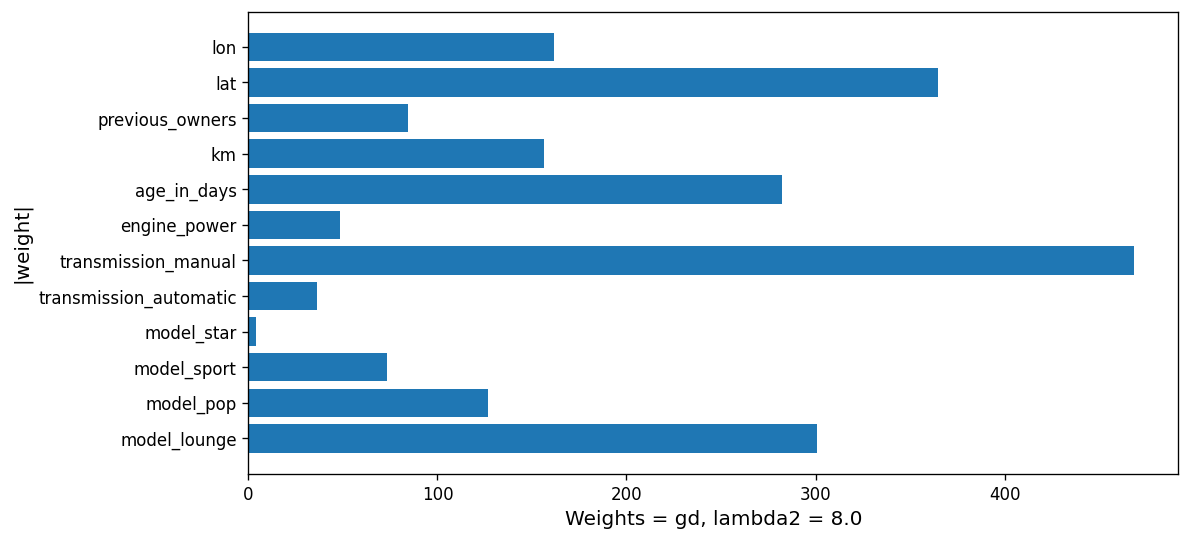

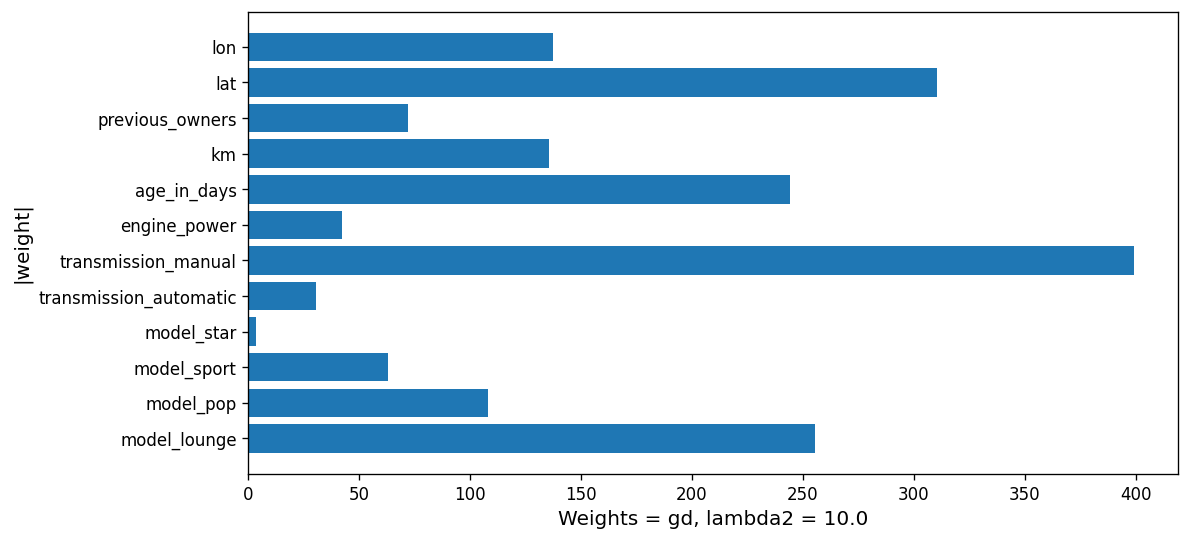

In [16]:
#В качестве оптимальных lambda1 возьмем 0.1 для gd, и 8 для sgd
l1 = 0.1
train_mae2, val_mae2, r2_score2, train_time2 = [],[],[],[]

for l in lambdas2:
    model = MyLinearRegression('l1l2', 'gd', l1, l)
    t = time.time()
    model.fit(X_train,y_train)
    train_time2.append(time.time() - t)

    score = model.score(X_test, y_test)
    r2_score2.append(score)
    train_mae2.append(np.mean(np.abs(np.asarray(y_train).reshape(-1, 1) - model.predict(X_train))))
    val_mae2.append(np.mean(np.abs(np.asarray(y_test).reshape(-1, 1) - model.predict(X_test))))

    if l in [0,0.5,2,4,6,8,10]:
        plt.barh(X_train.columns, np.abs(model.coefs_.flatten()))
        plt.xlabel("Weights = gd, lambda2 = " + str(l))
        plt.ylabel("|weight|")
        plt.show()



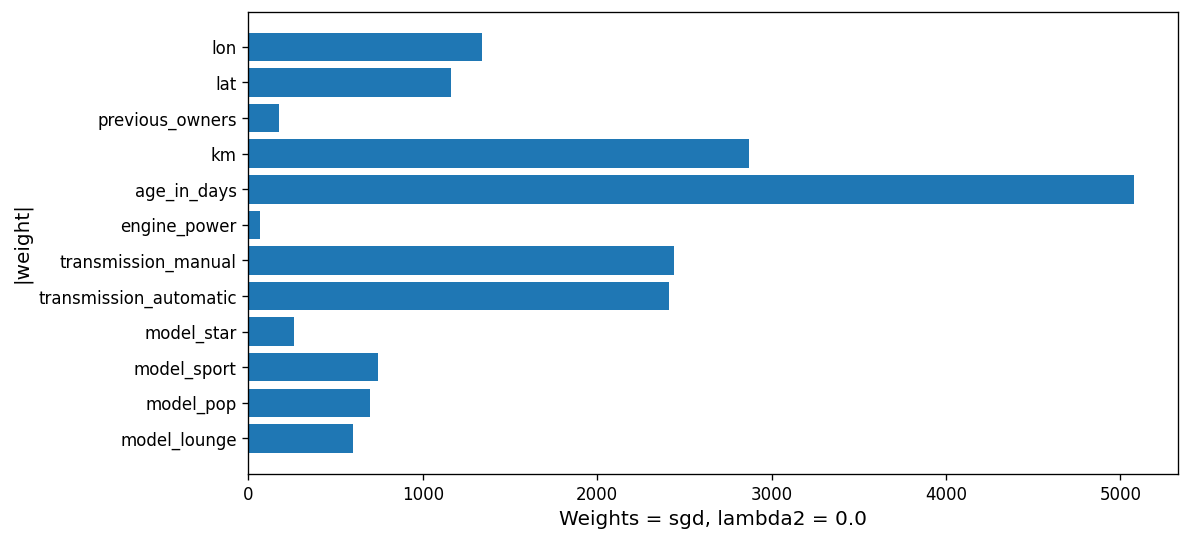

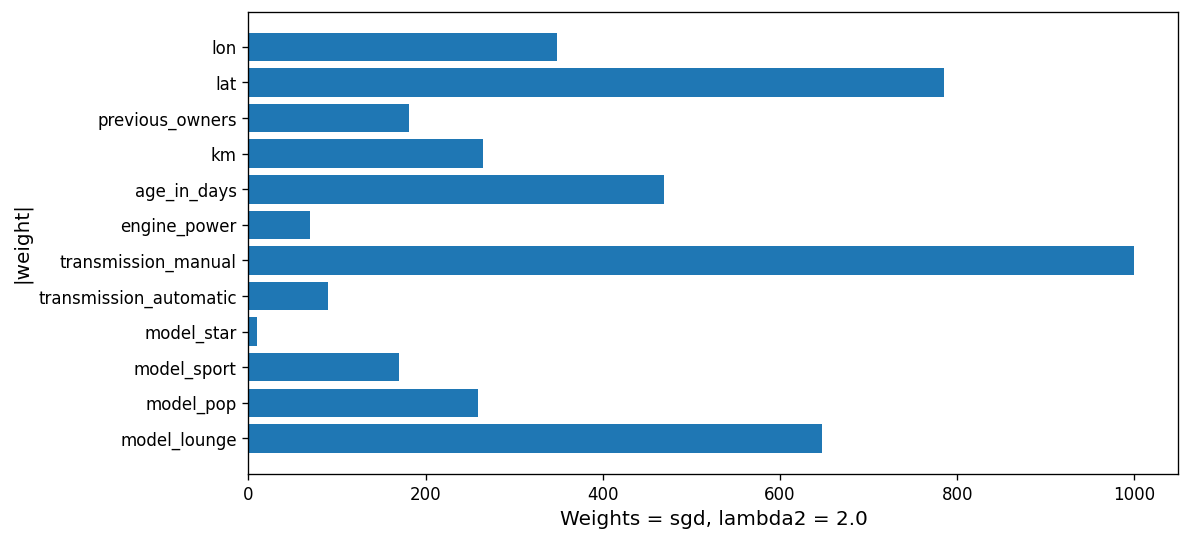

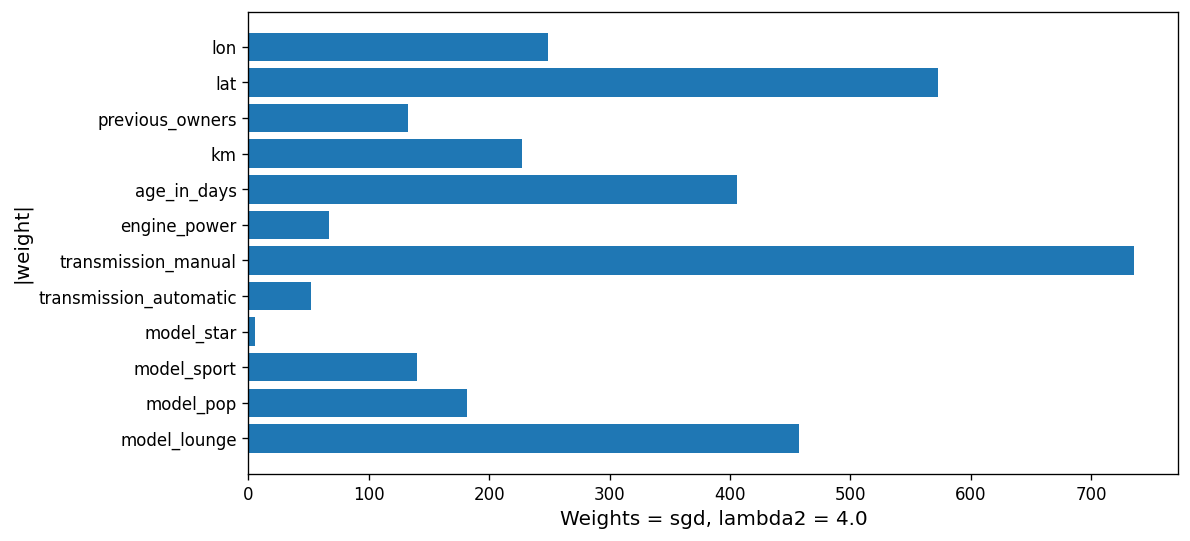

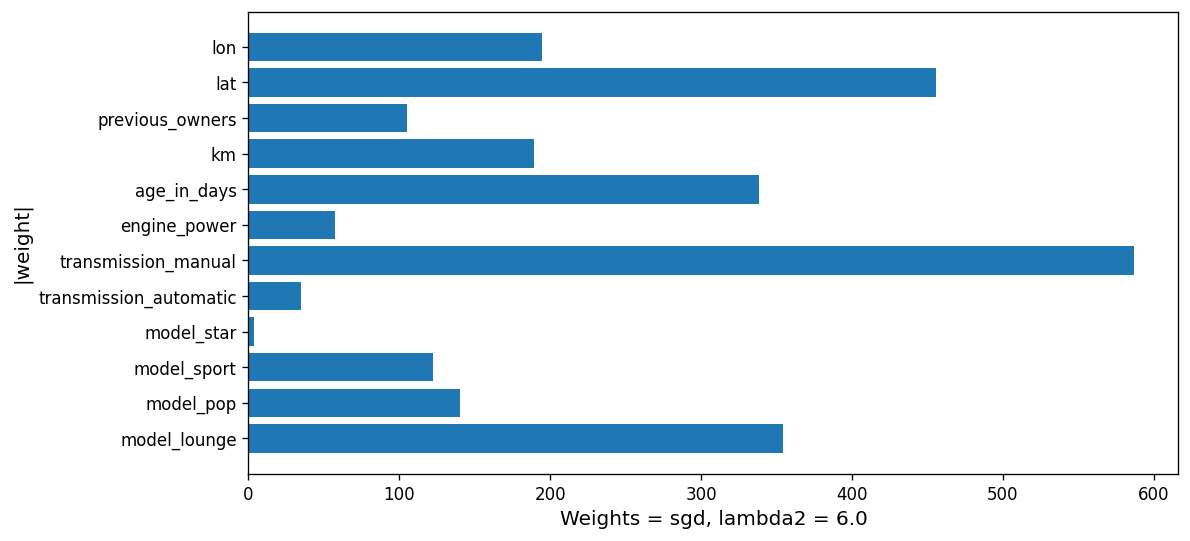

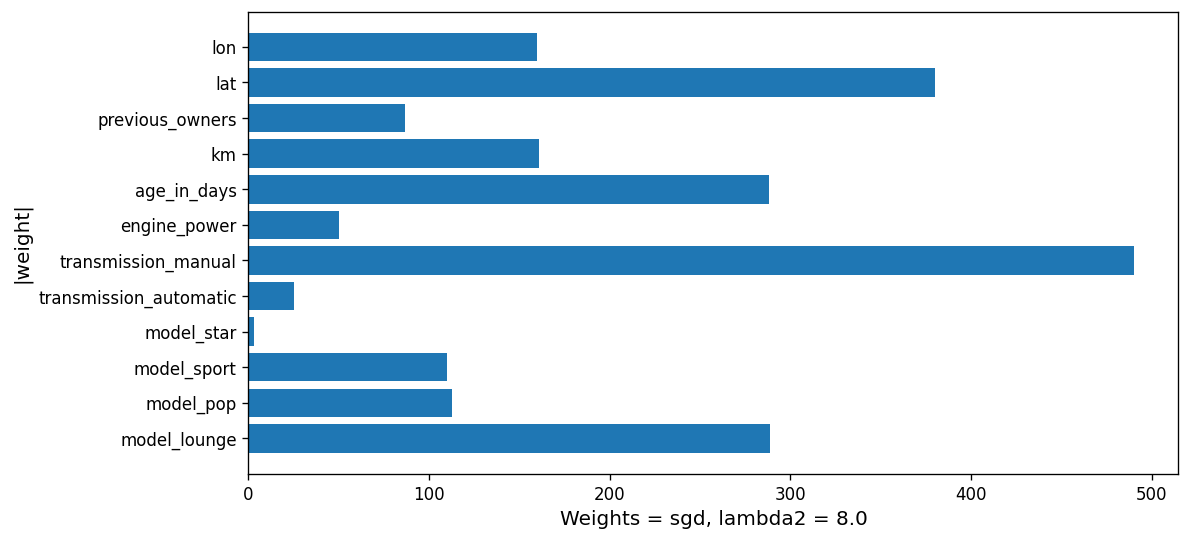

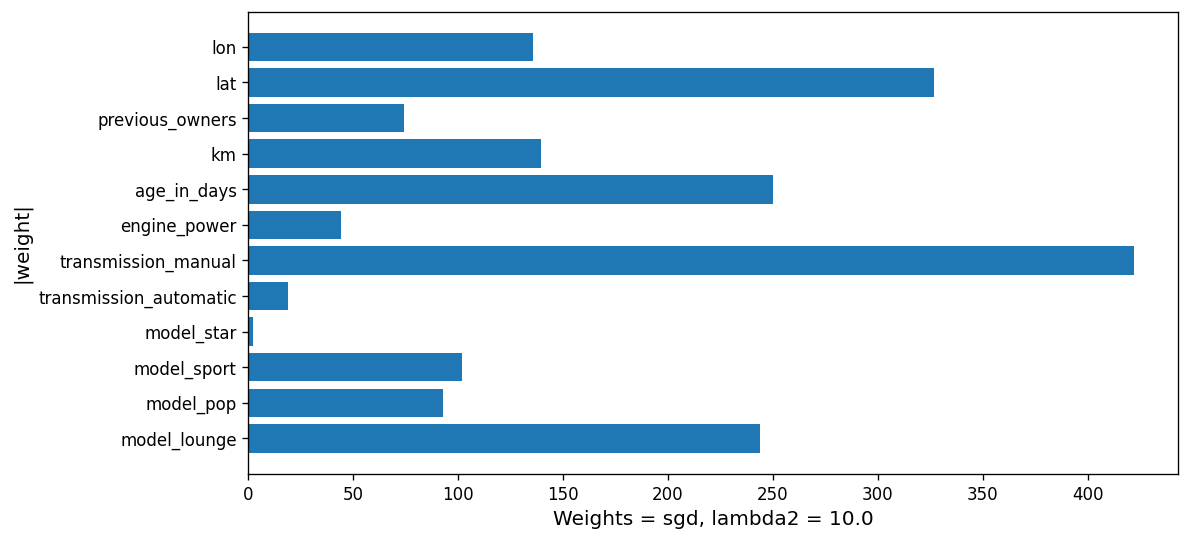

In [17]:

l1 = 8
train_mae3, val_mae3, r2_score3, train_time3 = [],[],[],[]

for l in lambdas2:
    model = MyLinearRegression('l1l2', 'sgd', l1, l)
    t = time.time()
    model.fit(X_train,y_train)
    train_time3.append(time.time() - t)

    score = model.score(X_test, y_test)
    r2_score3.append(score)
    train_mae3.append(np.mean(np.abs(np.asarray(y_train).reshape(-1, 1) - model.predict(X_train))))
    val_mae3.append(np.mean(np.abs(np.asarray(y_test).reshape(-1, 1) - model.predict(X_test))))

    if l in [0,0.5,2,4,6,8,10]:
        plt.barh(X_train.columns, np.abs(model.coefs_.flatten()))
        plt.xlabel("Weights = sgd, lambda2 = " + str(l))
        plt.ylabel("|weight|")
        plt.show()

train_mae_l2, val_mae_l2, r2_score_l2, train_time_l2 = train_mae3, val_mae3, r2_score3, train_time3


В среднем результаты те же, что и при l1 регуляризации. Признаки не зануляются (не то чтобы они часто занулялись ранее, но тут хуже).

Text(0, 0.5, 'MAE')

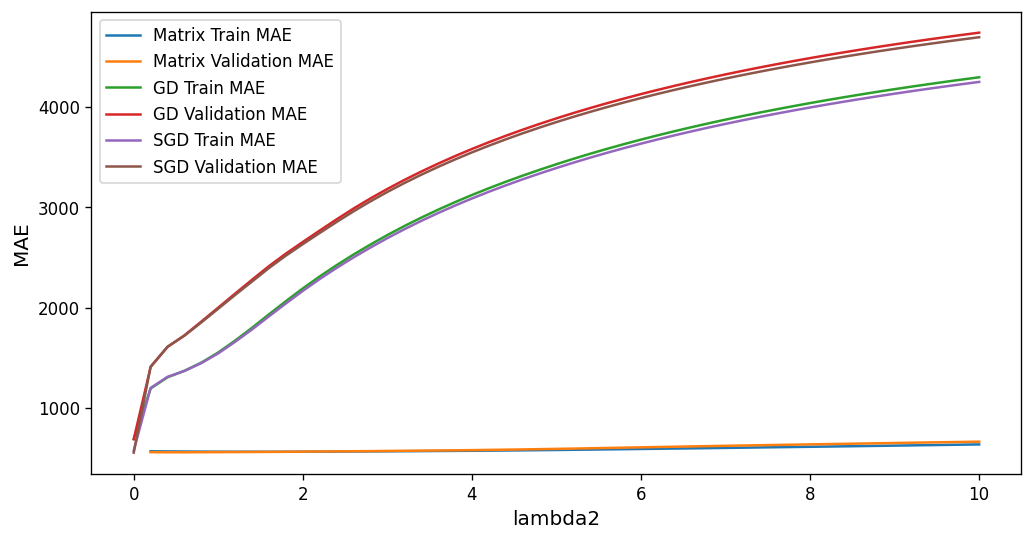

In [ ]:
plt.plot(lambdas1, train_mae1, label = 'Matrix Train MAE')
plt.plot(lambdas1, val_mae1, label = 'Matrix Validation MAE')
plt.plot(lambdas2, train_mae2, label = 'GD Train MAE')
plt.plot(lambdas2, val_mae2, label = 'GD Validation MAE')
plt.plot(lambdas2, train_mae3, label = 'SGD Train MAE')
plt.plot(lambdas2, val_mae3, label = 'SGD Validation MAE')
plt.legend()
plt.xlabel('lambda2')
plt.ylabel('MAE')

Text(0, 0.5, 'R^2 score')

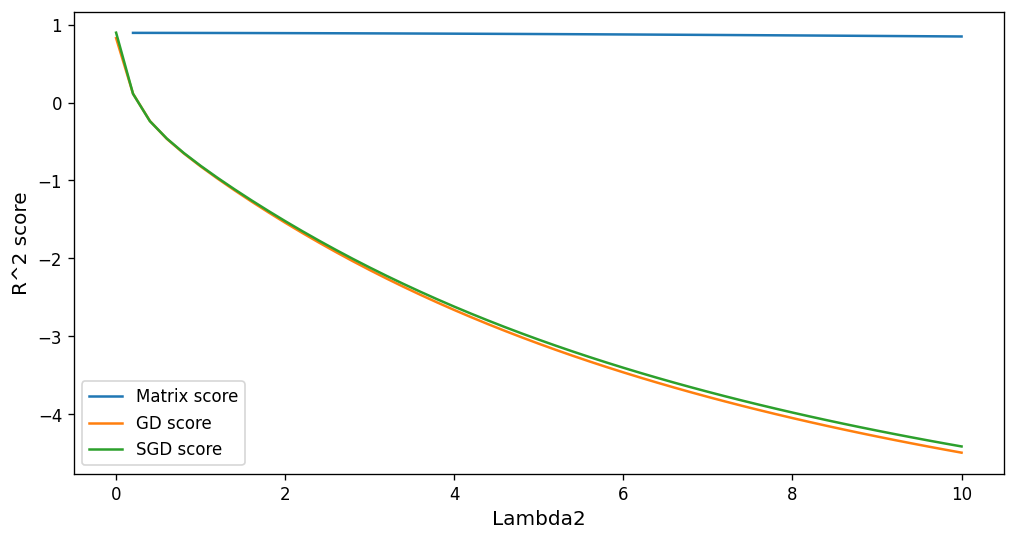

In [ ]:
plt.plot(lambdas1, r2_score1, label = 'Matrix score')
plt.plot(lambdas2, r2_score2, label = 'GD score')
plt.plot(lambdas2, r2_score3, label = 'SGD score')

plt.legend()
plt.xlabel('Lambda2')
plt.ylabel('R^2 score')

Без l2 модель показывает себя лучше. Возможно l1 и l2 плохо тут сочетаются, так как для матриц он неплох.

Text(0, 0.5, 'Time')

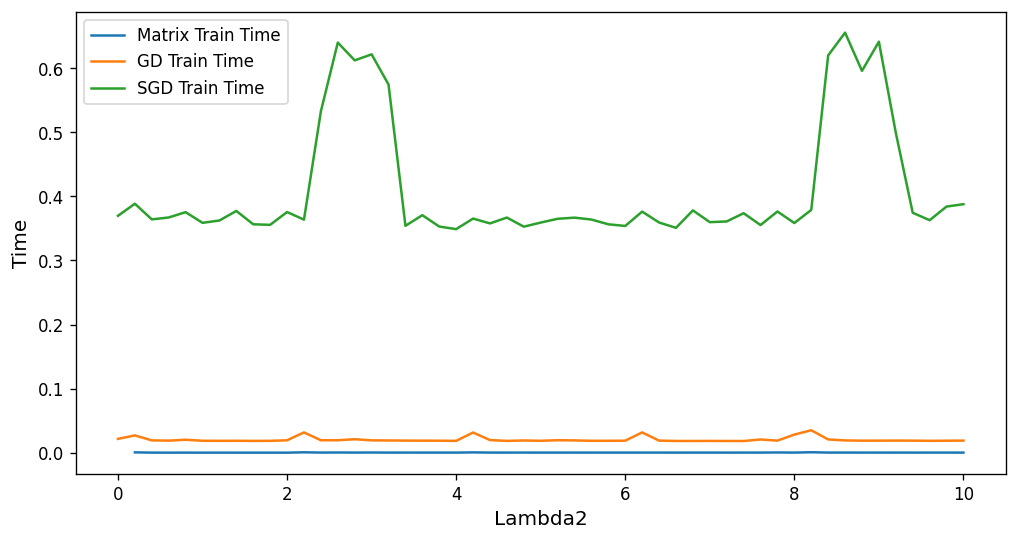

In [ ]:
plt.plot(lambdas1, train_time1, label = 'Matrix Train Time')
plt.plot(lambdas2, train_time2, label = 'GD Train Time')
plt.plot(lambdas2, train_time3, label = 'SGD Train Time')

plt.legend()
plt.xlabel('Lambda2')
plt.ylabel('Time')

С l2 также трейн медленее, чем без него.

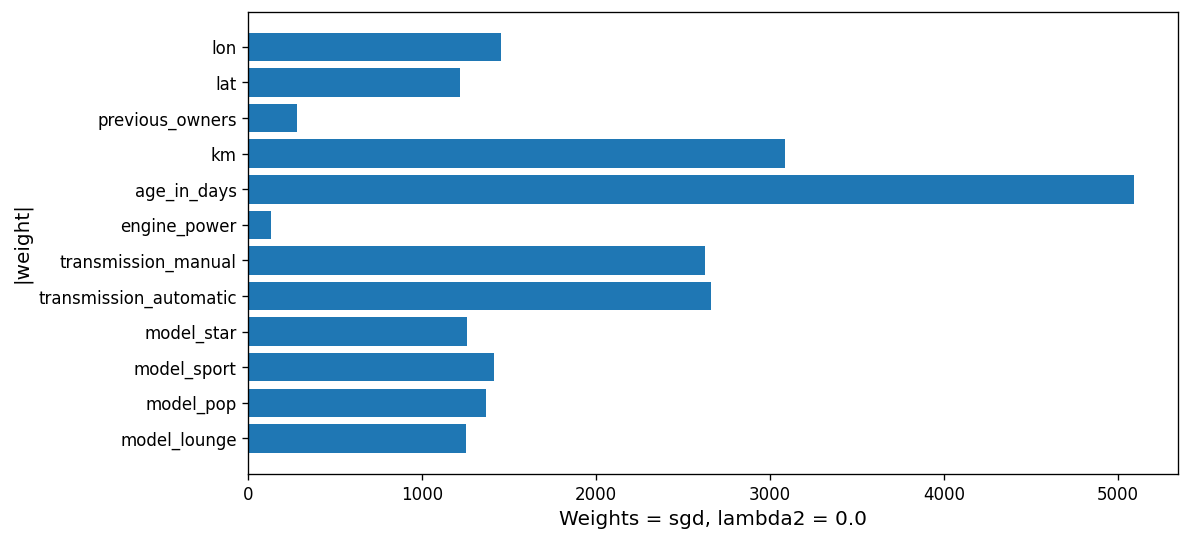

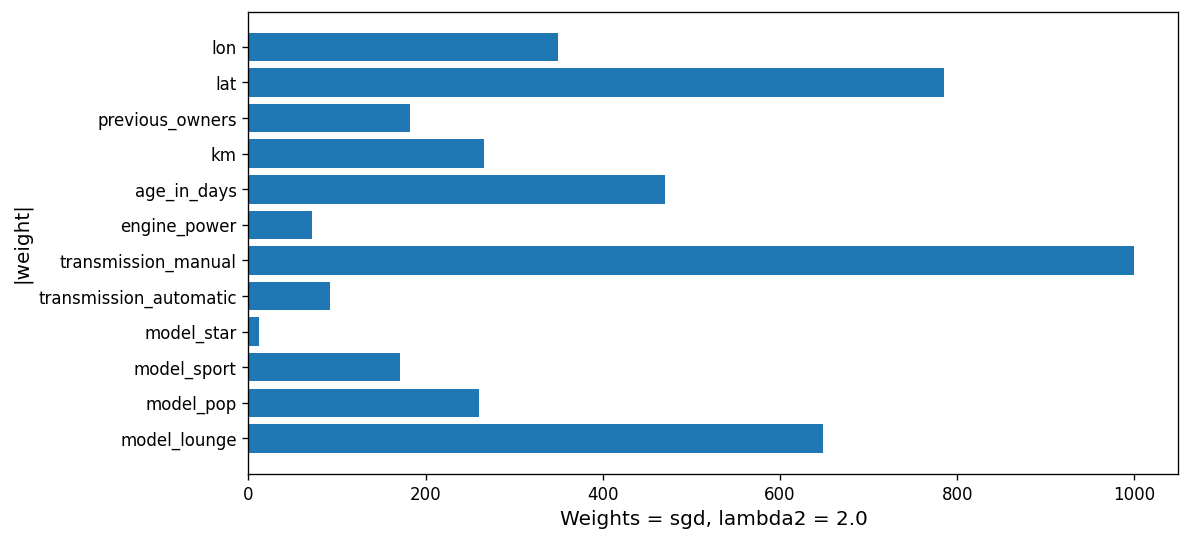

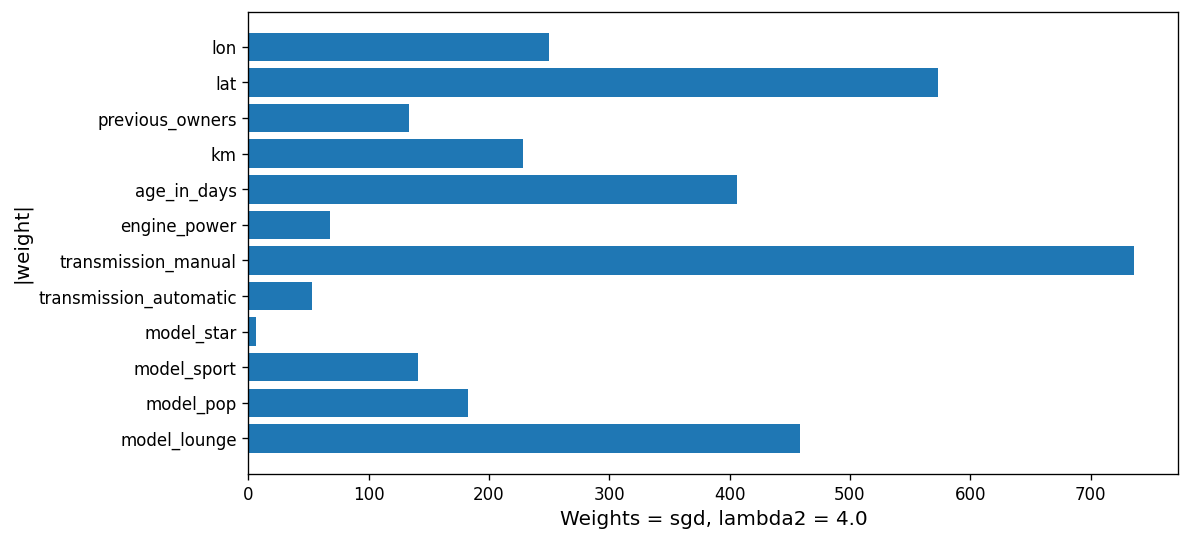

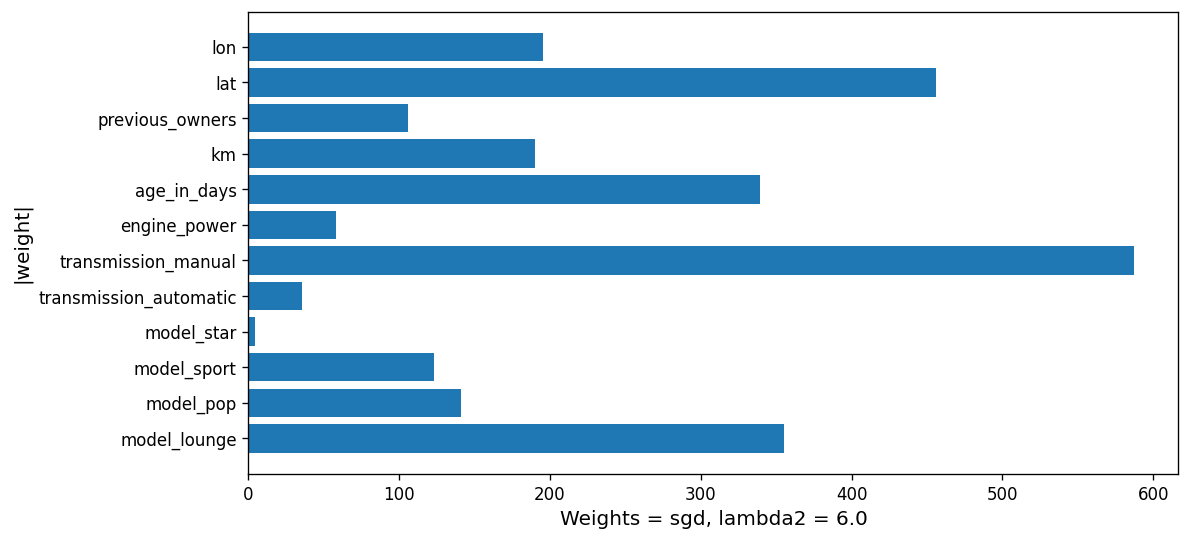

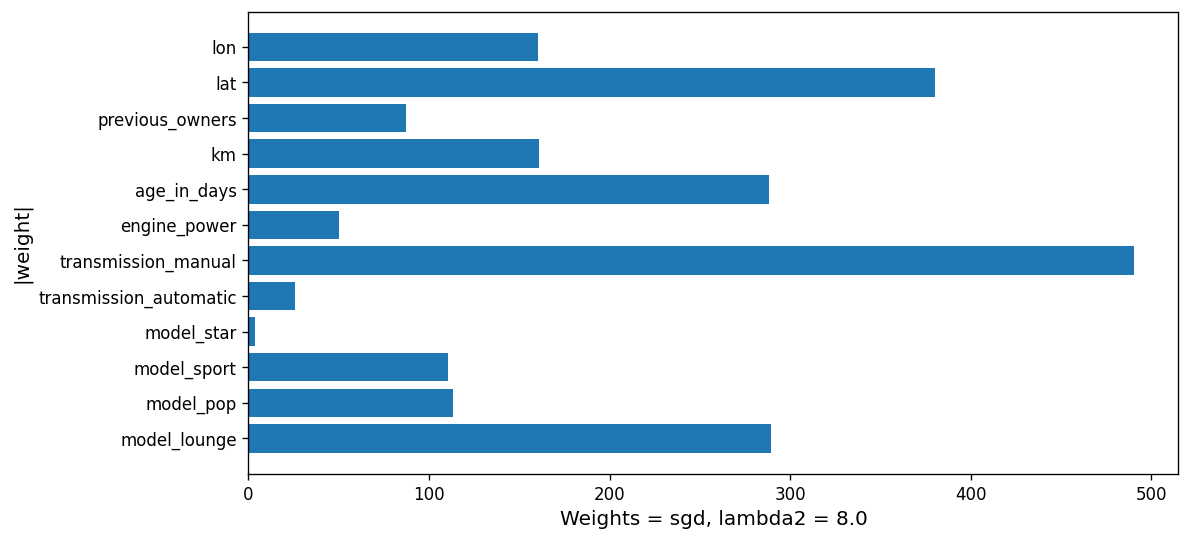

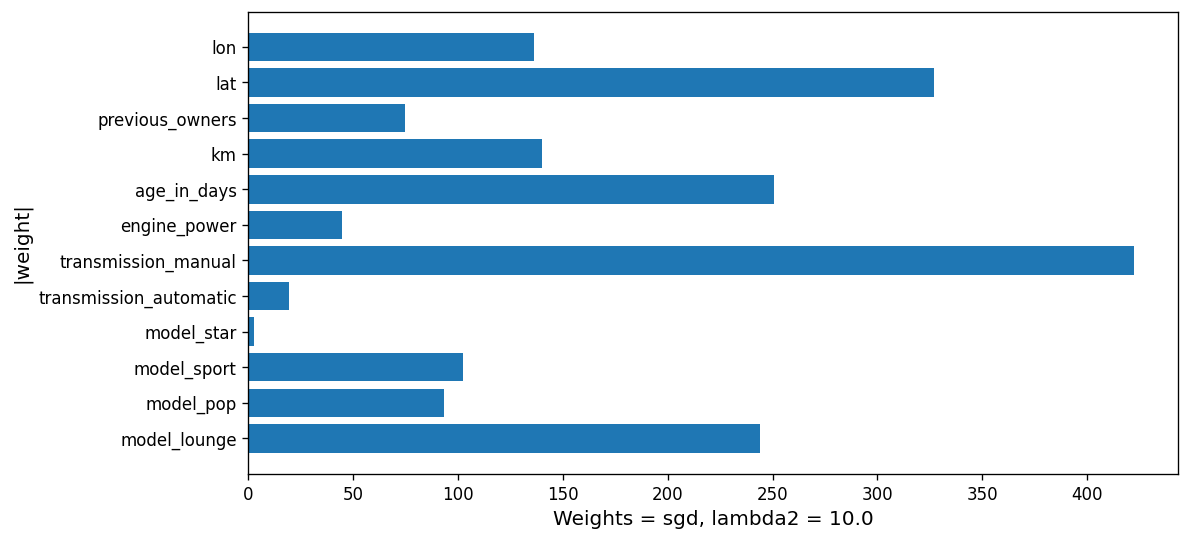

In [13]:
#Глянем l2 без l1
train_mae3, val_mae3, r2_score3, train_time3 = [],[],[],[]

for l in lambdas2:
    model = MyLinearRegression('l2', 'sgd', 1, l)
    t = time.time()
    model.fit(X_train,y_train)
    train_time3.append(time.time() - t)

    score = model.score(X_test, y_test)
    r2_score3.append(score)
    train_mae3.append(np.mean(np.abs(np.asarray(y_train).reshape(-1, 1) - model.predict(X_train))))
    val_mae3.append(np.mean(np.abs(np.asarray(y_test).reshape(-1, 1) - model.predict(X_test))))

    if l in [0,0.5,2,4,6,8,10]:
        plt.barh(X_train.columns, np.abs(model.coefs_.flatten()))
        plt.xlabel("Weights = sgd, lambda2 = " + str(l))
        plt.ylabel("|weight|")
        plt.show()


Text(0, 0.5, 'R^2 score')

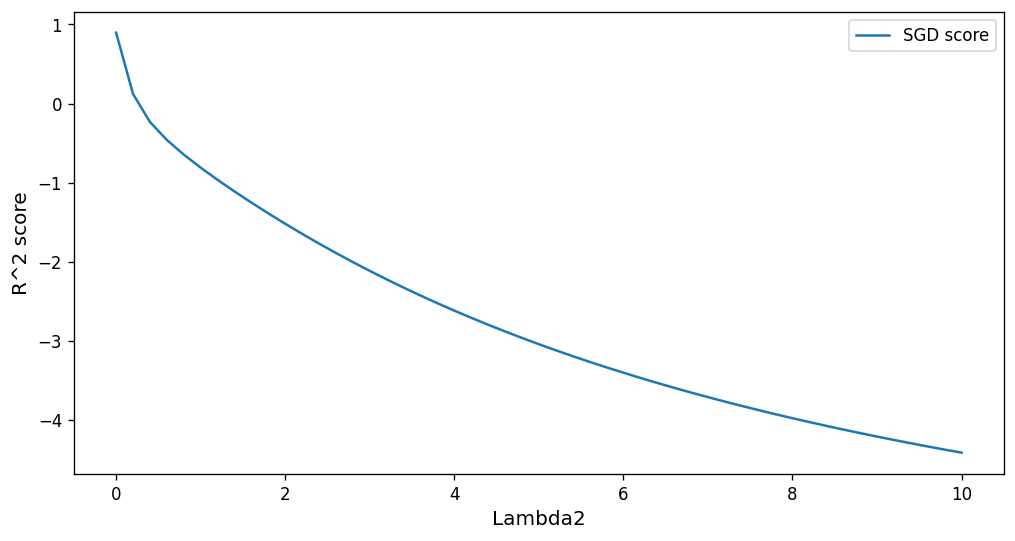

In [ ]:

plt.plot(lambdas2, r2_score3, label = 'SGD score')

plt.legend()
plt.xlabel('Lambda2')
plt.ylabel('R^2 score')

Тоже самое. Возможно оптимальное lambda2 просто очень маленькое.

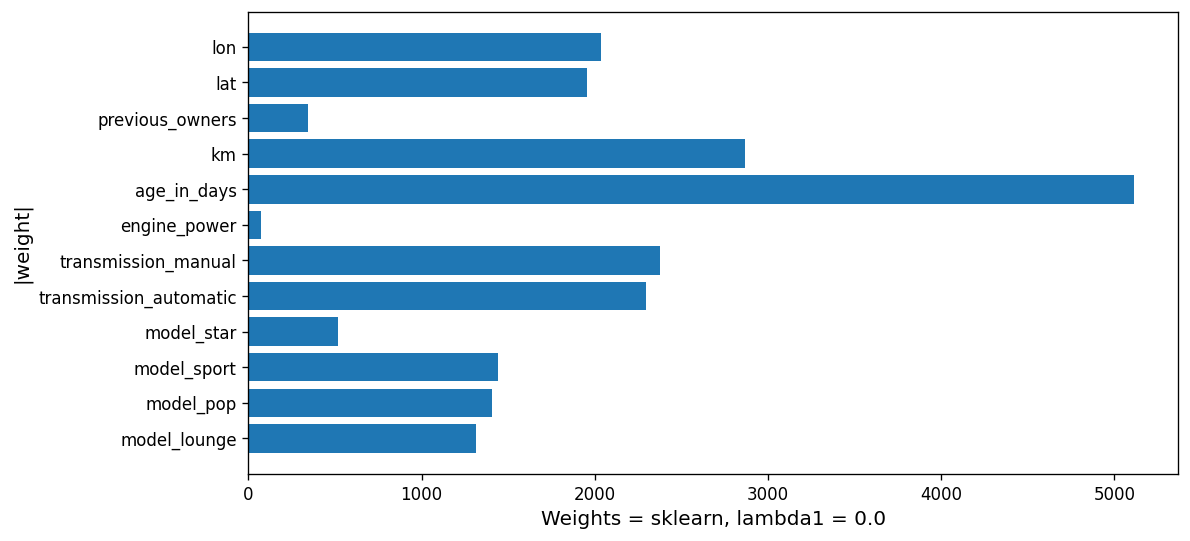

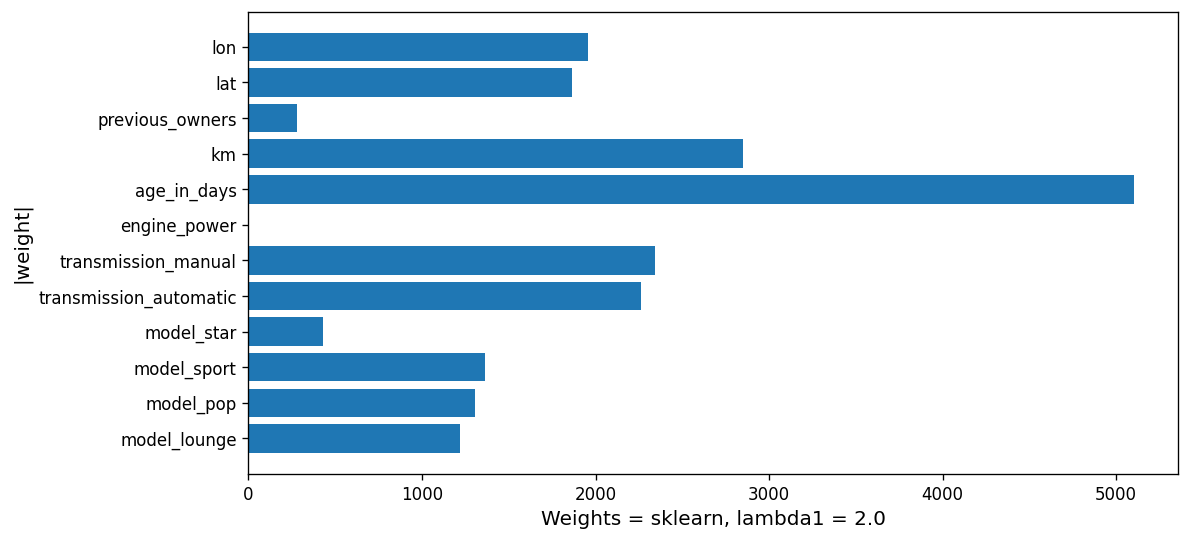

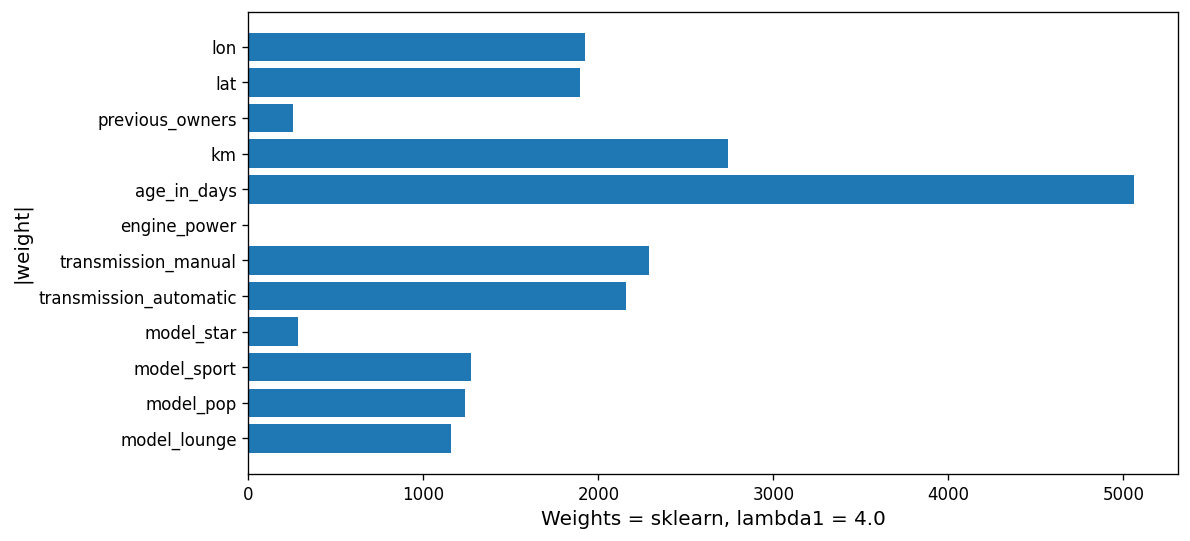

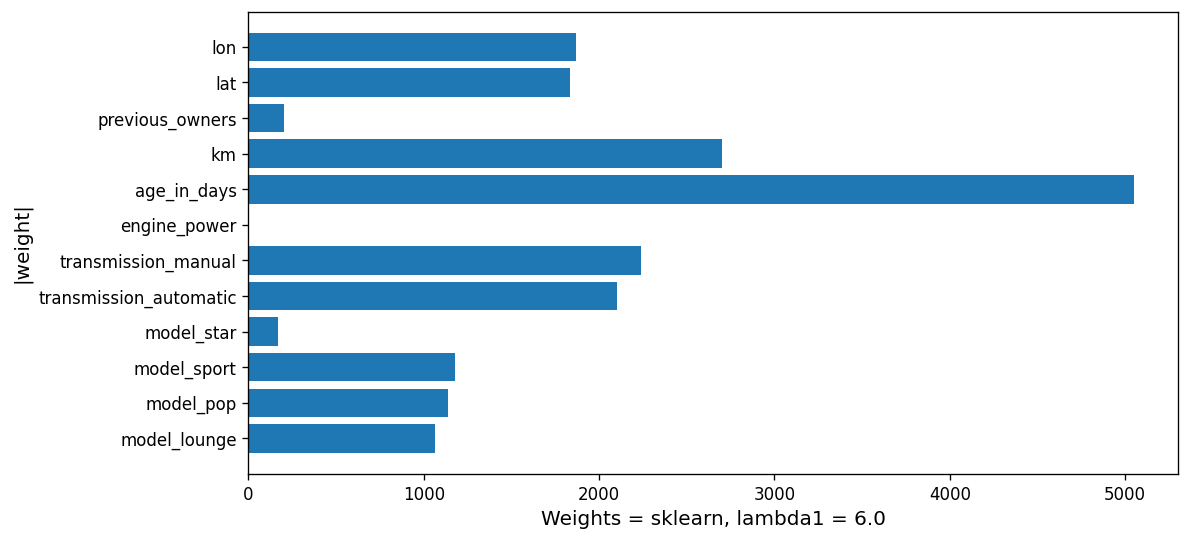

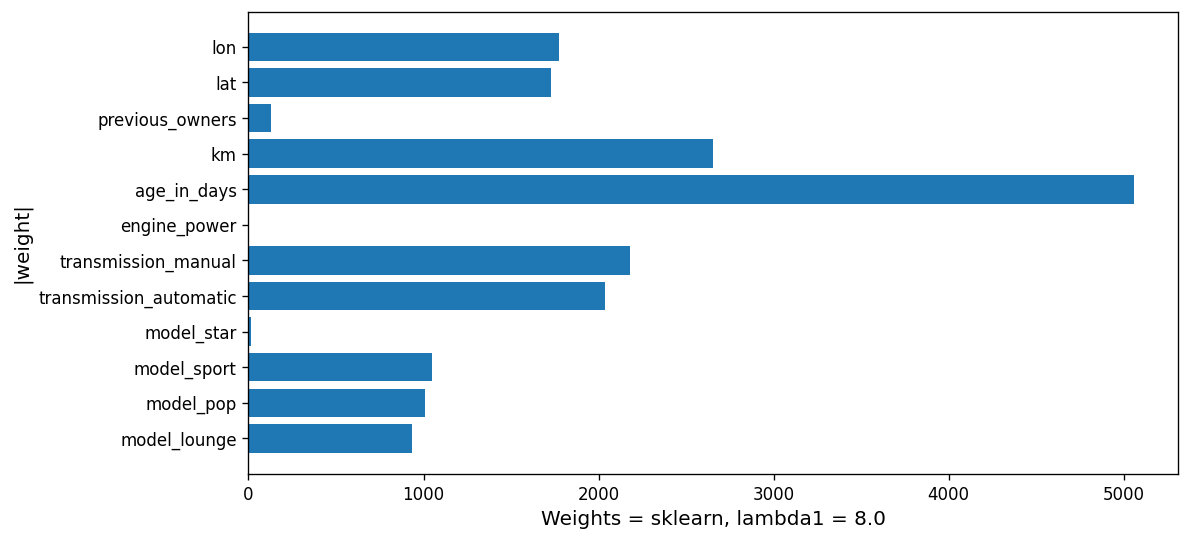

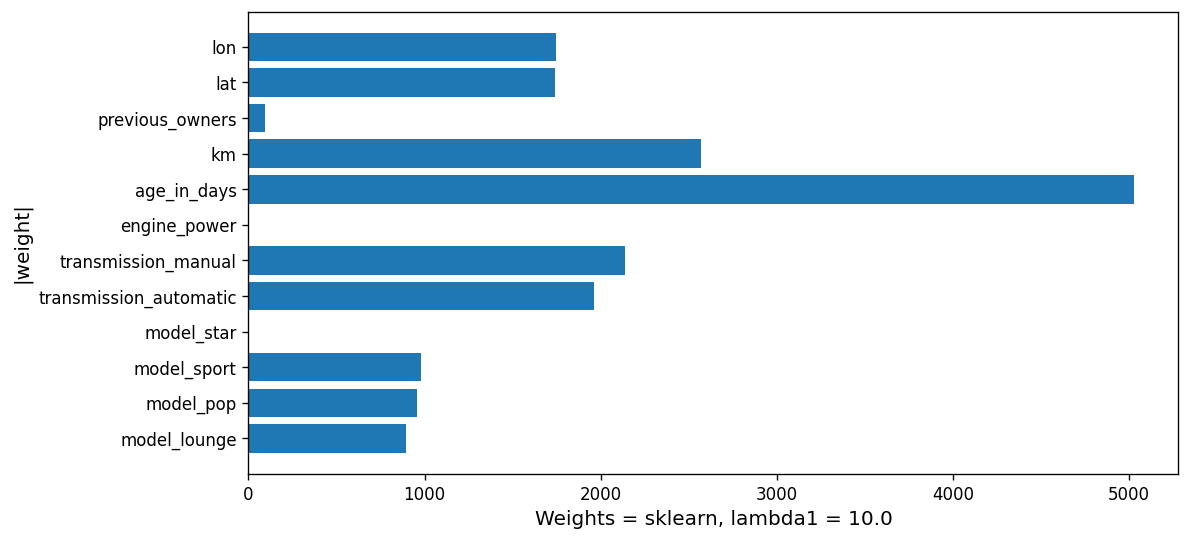

In [20]:
# Посмотрим на реализацию SGD с l1 регуляризацией из sklearn
from sklearn.linear_model import SGDRegressor


lambdas2 = np.arange(0, 10.01, 0.2)

train_mae_sk, val_mae_sk, r2_score_sk, train_time_sk = [],[],[],[]


for l in lambdas2:
    model = SGDRegressor(penalty = 'l1', alpha=l)
    t = time.time()
    model.fit(X_train,y_train)
    train_time_sk.append(time.time() - t)

    score = model.score(X_test, y_test)
    r2_score_sk.append(score)
    train_mae_sk.append(np.mean(np.abs(np.asarray(y_train).reshape(-1, 1) - model.predict(X_train))))
    val_mae_sk.append(np.mean(np.abs(np.asarray(y_test).reshape(-1, 1) - model.predict(X_test))))

    if l in [0,0.5,2,4,6,8,10]:
        plt.barh(X_train.columns, np.abs(model.coef_.flatten()))
        plt.xlabel("Weights = sklearn, lambda1 = " + str(l))
        plt.ylabel("|weight|")
        plt.show()

Вывод: стандартная реализация lasso регрессии быстрее зануляет признаки (проводит их отбор). С увеличением lambda как и у нашей модели зануляются engine_power и model_star.

Сравним библиотечную реализацию с нашим sgd по разным lambda

Text(0, 0.5, 'MAE')

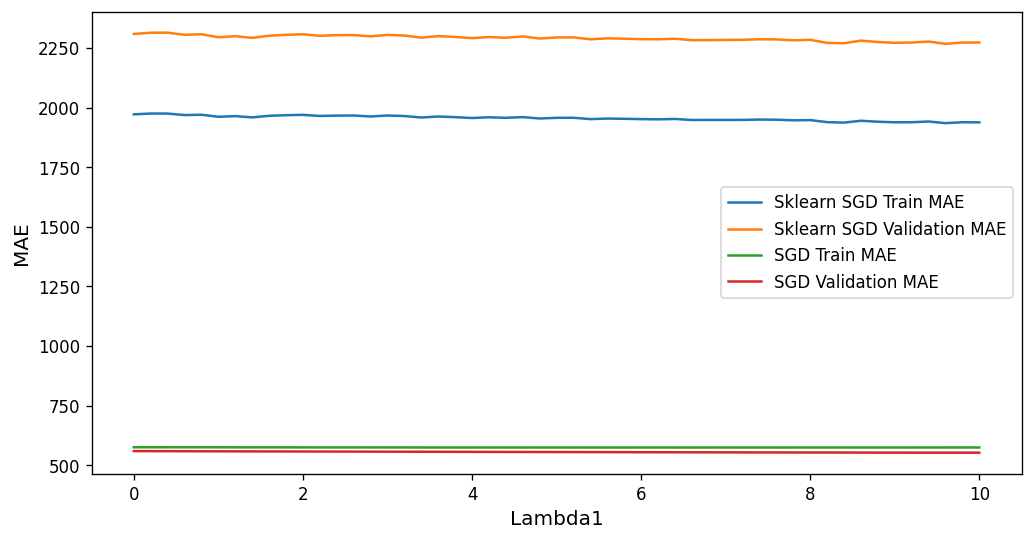

In [22]:
plt.plot(lambdas2, train_mae_sk, label = 'Sklearn SGD Train MAE')
plt.plot(lambdas2, val_mae_sk, label = 'Sklearn SGD Validation MAE')
plt.plot(lambdas2, train_mae_l1, label = 'SGD Train MAE')
plt.plot(lambdas2, val_mae_l1, label = 'SGD Validation MAE')
plt.legend()
plt.xlabel('Lambda1')
plt.ylabel('MAE')

Text(0, 0.5, 'R^2 score')

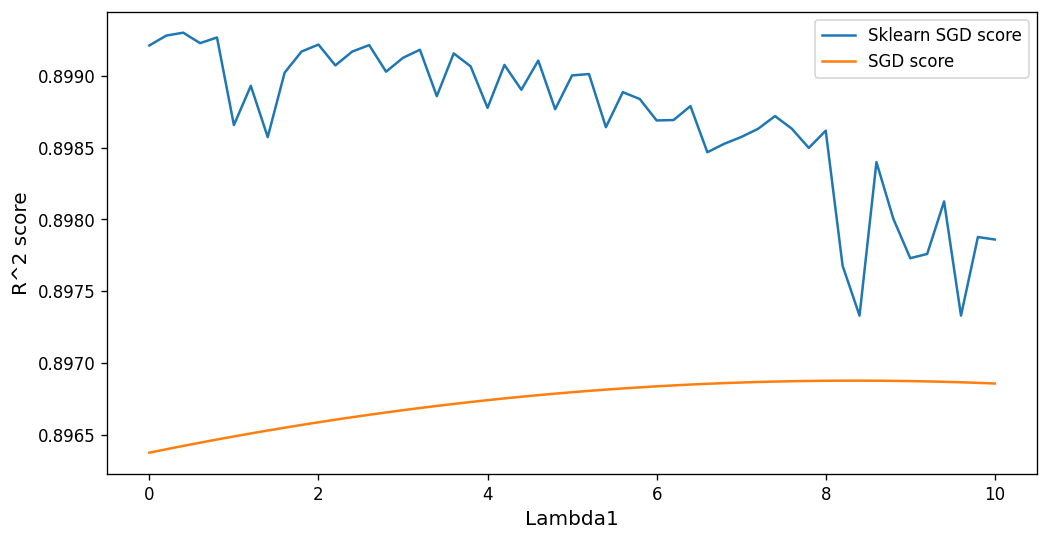

In [23]:
plt.plot(lambdas2, r2_score_sk, label = 'Sklearn SGD score')
plt.plot(lambdas2, r2_score_l1, label = 'SGD score')

plt.legend()
plt.xlabel('Lambda1')
plt.ylabel('R^2 score')

Вывод: в целом наша модель при стандартных параметрах смогла обойти по MAE библиотечную, но проиграла по R^2 метрике. Однако с ростом lambda1 R^2 становится сопоставимым.

Text(0, 0.5, 'Time')

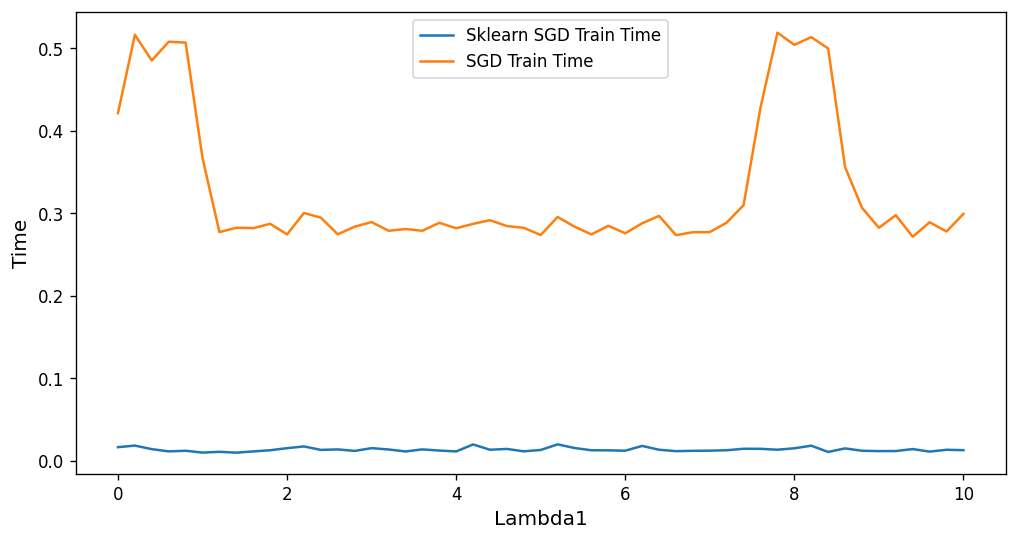

In [25]:

plt.plot(lambdas2, train_time_sk, label = 'Sklearn SGD Train Time')
plt.plot(lambdas2, train_time_l1, label = 'SGD Train Time')

plt.legend()
plt.xlabel('Lambda1')
plt.ylabel('Time')

Вывод: из минусов видим, что наша модель существенно медленнее на обучении, и имеет большой разброс.

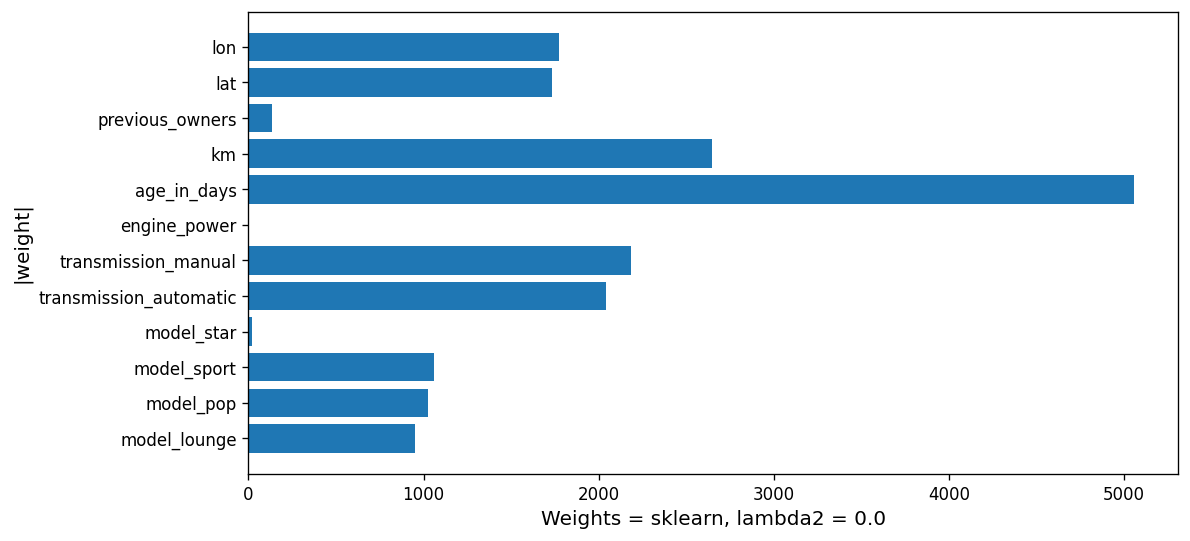

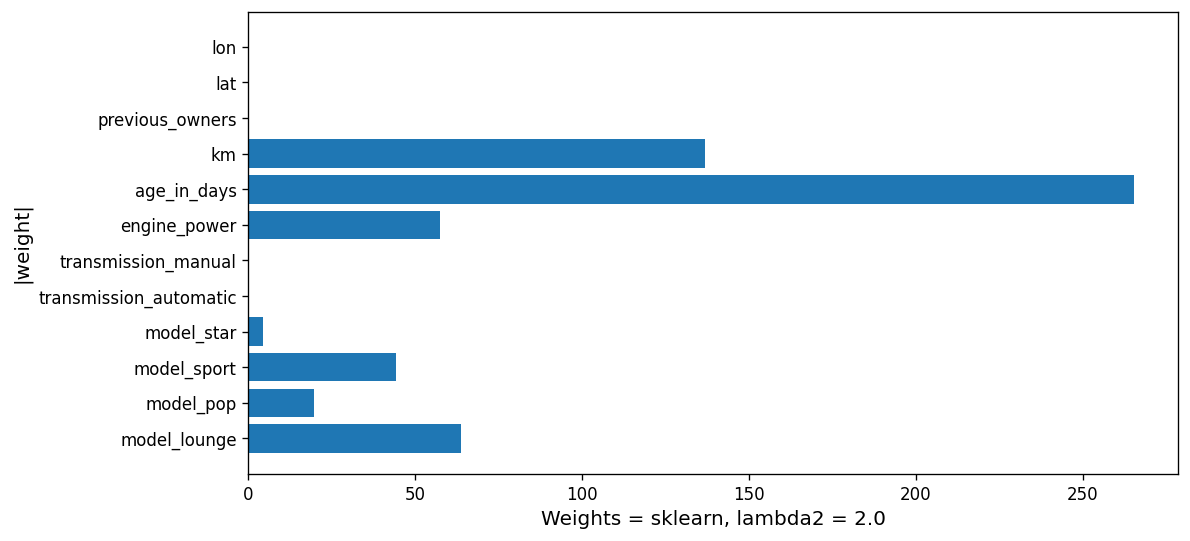

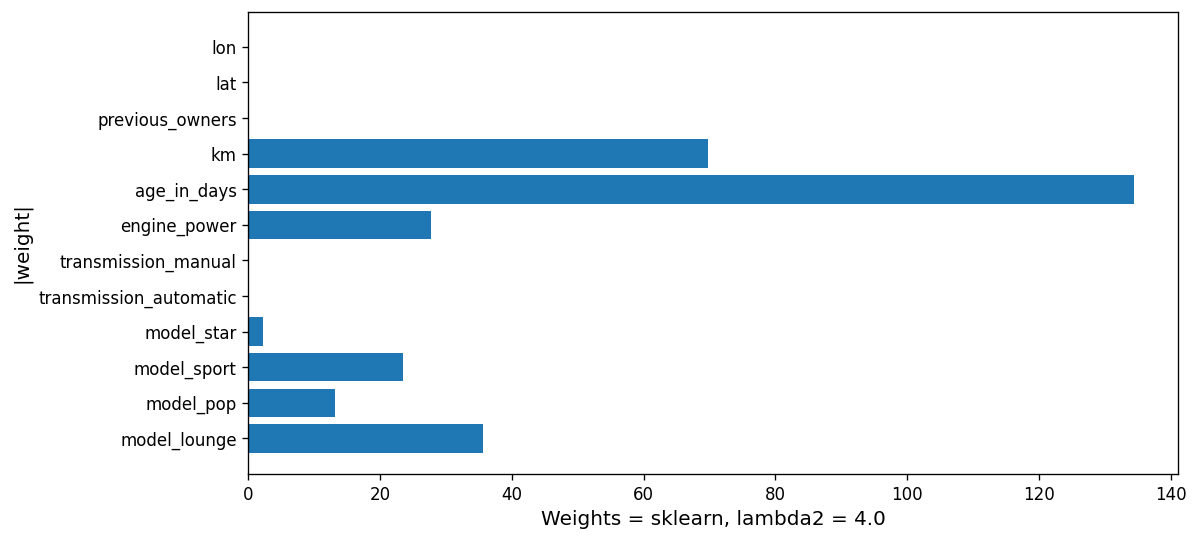

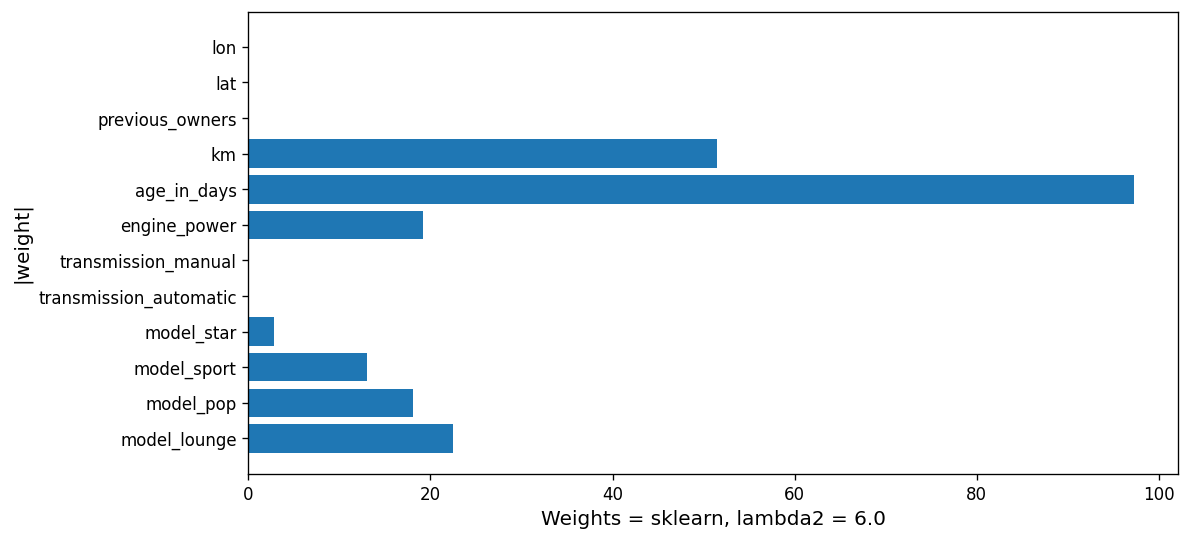

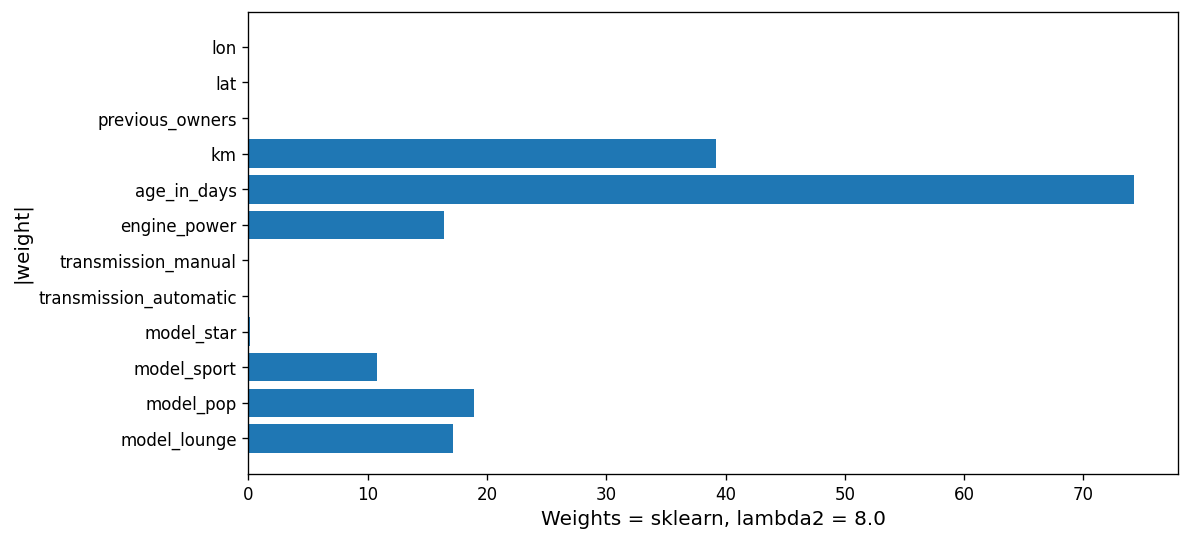

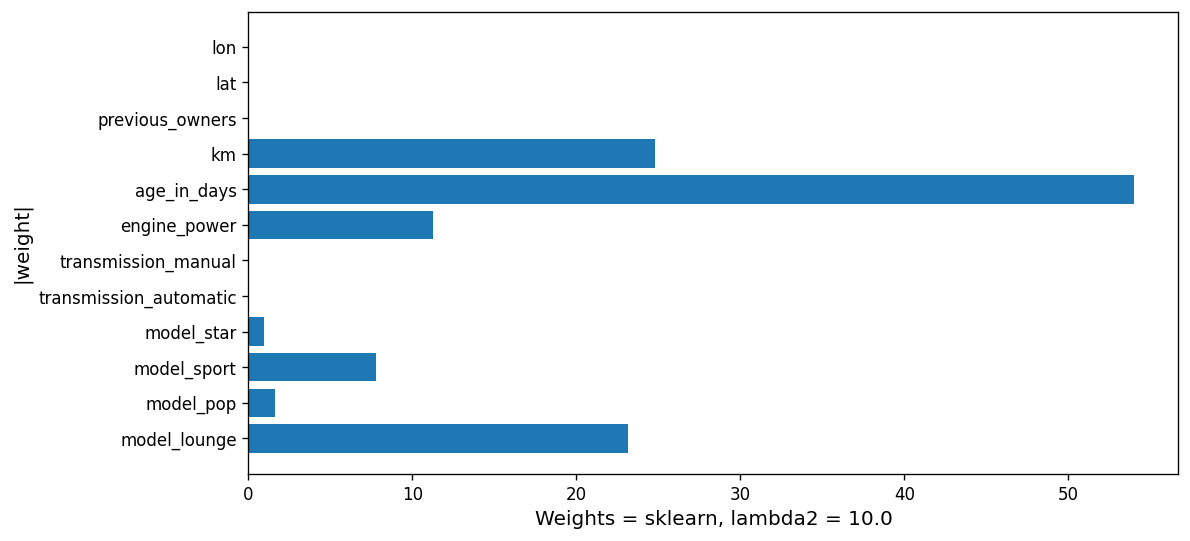

In [27]:
#Теперь сравним наш sgd с l1l2 регуляризацией с аналогичной из sklearn
#l1 будет фиксированным, и как у нашего sgd = 8

l1 = 8
train_mae3, val_mae3, r2_score3, train_time3 = [],[],[],[]

for l in lambdas2:
    model = SGDRegressor(penalty = 'elasticnet', alpha=l+l1, l1_ratio=l1/(l+l1))
    t = time.time()
    model.fit(X_train,y_train)
    train_time3.append(time.time() - t)

    score = model.score(X_test, y_test)
    r2_score3.append(score)
    train_mae3.append(np.mean(np.abs(np.asarray(y_train).reshape(-1, 1) - model.predict(X_train))))
    val_mae3.append(np.mean(np.abs(np.asarray(y_test).reshape(-1, 1) - model.predict(X_test))))

    if l in [0,0.5,2,4,6,8,10]:
        plt.barh(X_train.columns, np.abs(model.coef_.flatten()))
        plt.xlabel("Weights = sklearn, lambda2 = " + str(l))
        plt.ylabel("|weight|")
        plt.show()

train_mae_sk, val_mae_sk, r2_score_sk, train_time_sk = train_mae3, val_mae3, r2_score3, train_time3

Вывод: опять видим, что веса расщепляются быстрее. При больших lambda2 обнулились 5 признаков.

Text(0, 0.5, 'MAE')

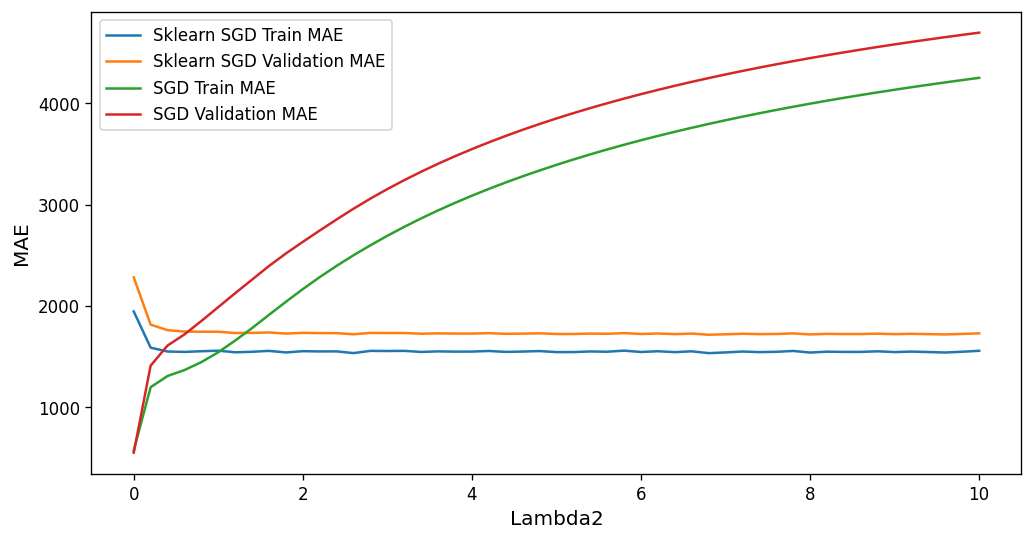

In [28]:
plt.plot(lambdas2, train_mae_sk, label = 'Sklearn SGD Train MAE')
plt.plot(lambdas2, val_mae_sk, label = 'Sklearn SGD Validation MAE')
plt.plot(lambdas2, train_mae_l2, label = 'SGD Train MAE')
plt.plot(lambdas2, val_mae_l2, label = 'SGD Validation MAE')
plt.legend()
plt.xlabel('Lambda2')
plt.ylabel('MAE')

Text(0, 0.5, 'R^2 score')

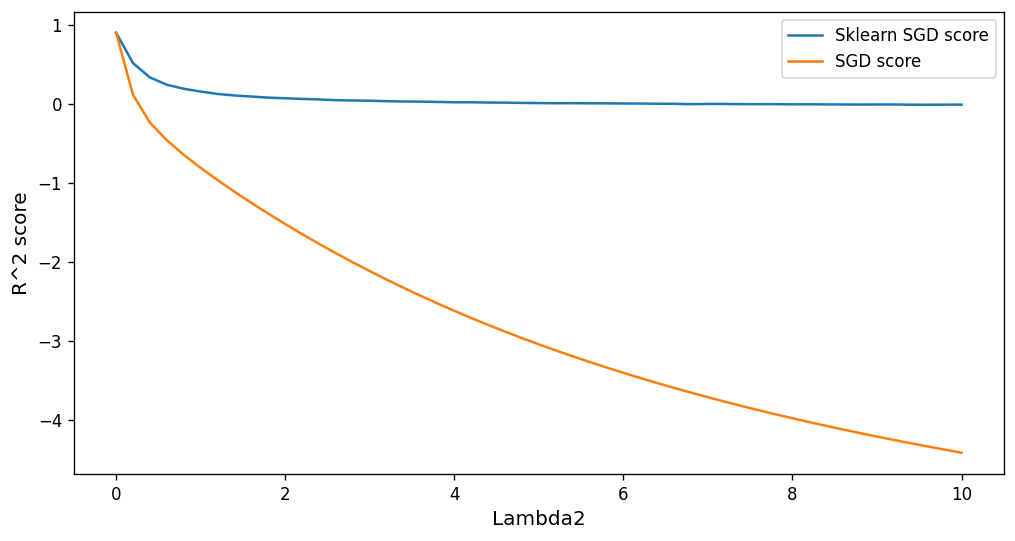

In [29]:
plt.plot(lambdas2, r2_score_sk, label = 'Sklearn SGD score')
plt.plot(lambdas2, r2_score_l2, label = 'SGD score')

plt.legend()
plt.xlabel('Lambda2')
plt.ylabel('R^2 score')

Вывод: видим, что l2 регуляризация так же плохо влияет на библиотечную реализацию, как и на нашу. Результаты в целом сопоставимы при маленьких lambda2, но у их модели качество падает не так драматично при больших значениях параметра. Возможно это связано с тем, что в sklearn параметр l2 попросту умножается на 0.5 для удобства.

Text(0, 0.5, 'Time')

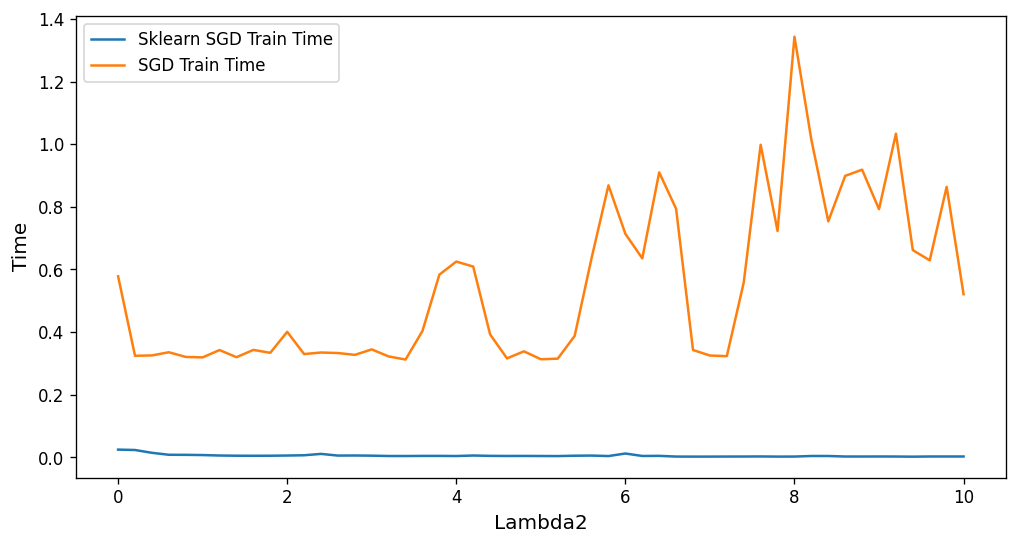

In [30]:

plt.plot(lambdas2, train_time_sk, label = 'Sklearn SGD Train Time')
plt.plot(lambdas2, train_time_l2, label = 'SGD Train Time')

plt.legend()
plt.xlabel('Lambda2')
plt.ylabel('Time')

Вывод: у нас опять же обучается дольше.

## Задача 2

[Соревнование на Kaggle](https://kaggle.com/competitions/yadro-regression-2025)